## Final Project Submission

Please fill out:
* Student name: Erik Castro
* Student pace:part time
* Scheduled project review date/time: 
* Instructor name: Eli
* Blog post URL:


# Introduction

My goal is to understand the data good enough to make a model to predict future prices of the houses in this area. 
There a few things I need to do before diving into that. 
I have to check which data is continous and which is categorical. 
I need to deal with this data differently, therefore I will separate them into two different datasets. 
The dataset is quite big, (21597) therefore I will have to take a more general approach towards cleaning the data. Not inspecting the data checking variables one by one. 



# Methodology

I will be using the OSEMiN Data Science Workflow: 


- Frame the problem: Identify business priorities and make strategic decisions that will lead my work
- Collect raw data: Extract data from the database provided.
- Process the Data: Understand the data and proceed to clean it. 
- Explore the data: Split the data in different ways and use statistics to test   and create visualizations to interpret data
- Perform In-Depth analysis:  Create multiple linear Regression model to         predict house prices. 
- Communicate Results: Explain findings with visualizations created before.      Present findings. 


## Importing libraries

In [2]:
import pandas as pd 
import sqlite3 as sql 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats

#train_test_split
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error, make_scorer,  explained_variance_score
from sklearn.model_selection import cross_val_predict, KFold, cross_validate, cross_val_score
from statsmodels.tools.tools import add_constant

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder


# Data Cleaning

In [3]:
df_housing = pd.read_csv('kc_house_data.csv')

In [4]:
df_housing.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


Check the info of the data, to analyze variable types

In [5]:
df_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


There are two object type in this data, I will change date to a dateTime object and Sqft_basement to float. This will make it easier to manipulate the data in the future.

In [6]:
#Transforms to data time object
def convert_datetime(df):
    df['date'] = pd.to_datetime(df['date'])
    return df

In [7]:
df_housing = convert_datetime(df_housing)

Changing sqft_basement to float.

In [8]:
df_housing['sqft_basement'].value_counts()

0.0       12826
?           454
600.0       217
500.0       209
700.0       208
          ...  
1852.0        1
65.0          1
862.0         1
2390.0        1
506.0         1
Name: sqft_basement, Length: 304, dtype: int64

There are 454 entries with '?' as a value, this could affect the findings hence I will set all this values to 0 which is less likely to interefere in the work.

In [9]:
#Replaces values ? to 0 
def replace(df):
    df['sqft_basement'] = df['sqft_basement'].map(lambda x : x.replace('?', '0'))
    return df

In [10]:
df_housing = replace(df_housing)

Checking that data has been changed

In [11]:
df_housing['sqft_basement'].value_counts()

0.0       12826
0           454
600.0       217
500.0       209
700.0       208
          ...  
862.0         1
2390.0        1
475.0         1
704.0         1
1852.0        1
Name: sqft_basement, Length: 304, dtype: int64

Changing the data to Float

In [12]:
df_housing['sqft_basement'] = df_housing['sqft_basement'].astype(float)

In [13]:
#Checking the sqft_basement has been changed to Float
df_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null datetime64[ns]
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null float64
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: datetime64[ns](1), float64(9), int64(11)
memory usage: 3.5

Checking the length of the data to make a decision whether empty columns will affect the studies

In [14]:
len(df_housing)

21597

Checking empty data

In [15]:
df_housing.isna().sum()

id                  0
date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

Total data is 21,597. However, we have 2,376 empty data in waterfront and 3,842 in year renovated. 
Meaning that 11% and 17%, respectively, of the data is missing at least a value. I reckon this more than enough to make a difference in the findings carried out in this study. Therefore, I will set the missing data to 0. 

In [16]:
df_housing = df_housing.fillna(0)

In [17]:
#Checking the data has been changed
df_housing.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

Time to check duplicate row names in the dataset. This could cause a problem in the future if is not dealt with now 

In [18]:
df_housing.duplicated().sum()

0

There are no duplicated rows in the dataset. 

Further Checking data

In [19]:
df_housing.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [20]:
df_housing.info(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null datetime64[ns]
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       21597 non-null float64
view             21597 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null float64
yr_built         21597 non-null int64
yr_renovated     21597 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: datetime64[ns](1), float64(9), int64(11)
memory usage: 3.5

Here we can see that floors, bathrooms and some other data  are on float. This could cause a labelling problem when dealing with categorical data in the future.

In [21]:
def rounding(df, cols):
    '''Round columns and convert to int'''
    for c in cols:
        df[c] = df[c].map(lambda x: int(round(x,0)))
    return df

In [22]:
columns = ['bathrooms', 'floors','waterfront', 'view',]
rounding(df_housing, columns)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1,1180,5650,1,0,0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2,2570,7242,2,0,0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1,770,10000,1,0,0,...,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3,1960,5000,1,0,0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2,1680,8080,1,0,0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,263000018,2014-05-21,360000.0,3,2,1530,1131,3,0,0,...,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,6600060120,2015-02-23,400000.0,4,2,2310,5813,2,0,0,...,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,1523300141,2014-06-23,402101.0,2,1,1020,1350,2,0,0,...,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,291310100,2015-01-16,400000.0,3,2,1600,2388,2,0,0,...,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


In [23]:
df_housing.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.0,3,1,1180,5650,1,0,0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000.0,3,2,2570,7242,2,0,0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000.0,2,1,770,10000,1,0,0,...,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000.0,4,3,1960,5000,1,0,0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000.0,3,2,1680,8080,1,0,0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


## Checking for Outliers

I want to check if there are extreme data in this dataset. I will be removing this data as I want the models to fit the majority of the data. I will be dropping entries with a z-score value bigger than 3. 

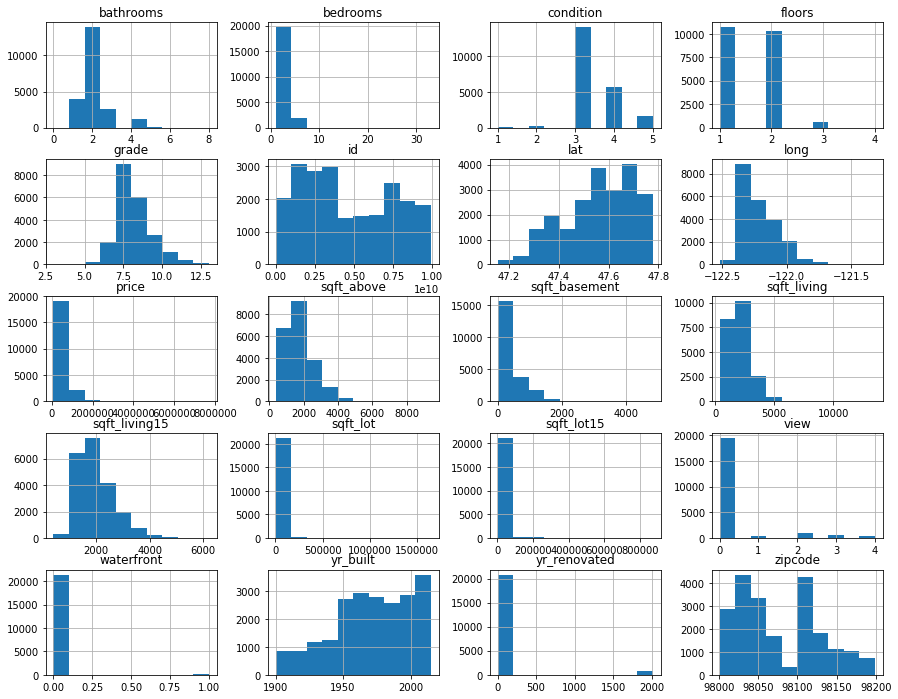

In [24]:
df_housing.hist(figsize = (15,12))
plt.show()

As thought, there are a number of columns that have outliers. This will be dealth with as explained above. 

In [25]:
def remove_outliers(df):
    variables = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_above', 
                 'lat', 'long', 'sqft_living15', 'sqft_lot15']
    
    for v in variables:
        df = df[np.abs(df[v]-df[v].mean()) <= (3*df[v].std())]
        
    return df

In [26]:
# Apply function to df_housing
df_housing = remove_outliers(df_housing)

Checking for outliers in price.

In [27]:
df_housing['price'].describe().round(3)


count      20278.000
mean      506955.887
std       281925.660
min        78000.000
25%       317000.000
50%       441625.000
75%       620000.000
max      3300000.000
Name: price, dtype: float64

There are houses with prices reaching 3300000.00, I want to limit the price range in the dataset as I believe extremely expensive houses will have a different set of values affecting the price.

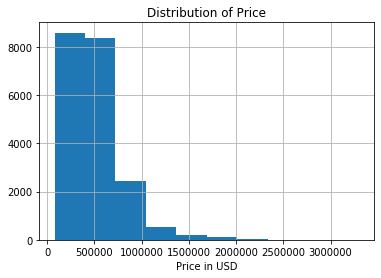

In [28]:

# View price distribution
df_housing['price'].hist()
plt.xlabel('Price in USD')
plt.title('Distribution of Price')
plt.show()

In [29]:
df_housing = df_housing[df_housing['price']<1500000]

# Question 1. 
## What month is better to buy a house? 

To answer this question I need to make some changes to the data. I want to extract only the month out of the data and use it to create some visualizations. 

In [30]:
df_housing['date']

0       2014-10-13
1       2014-12-09
2       2015-02-25
3       2014-12-09
4       2015-02-18
           ...    
21592   2014-05-21
21593   2015-02-23
21594   2014-06-23
21595   2015-01-16
21596   2014-10-15
Name: date, Length: 20022, dtype: datetime64[ns]

In [31]:
df_housing['month'] = df_housing['date'].dt.month

In [32]:
df_housing['month']

0        10
1        12
2         2
3        12
4         2
         ..
21592     5
21593     2
21594     6
21595     1
21596    10
Name: month, Length: 20022, dtype: int64

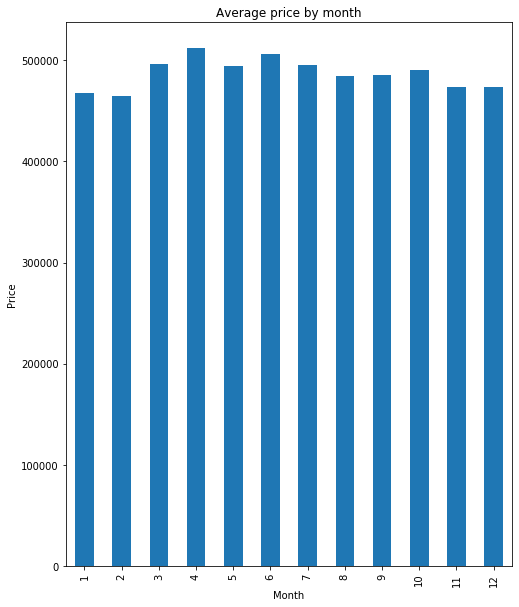

In [33]:
fig, ax = plt.subplots(figsize=(8,10))
df_housing.groupby('month')['price'].mean().plot.bar()
plt.xlabel('Month')
plt.ylabel('Price')
plt.title('Average price by month')
plt.show()

This visualization is providing a lot of information, perhaps is easier to do it by season. 

In [34]:
season = {
    1: 'Winter',
    2: 'Winter',
    3: 'Spring',
    4: 'Spring',
    5: 'Spring',
    6: 'Summer',
    7: 'Summer',
    8: 'Summer',
    9: 'Autumn',
    10: 'Autumn',
    11: 'Autumn',
    12: 'Winter',
}
df_housing['season'] = df_housing['month'].replace(season)

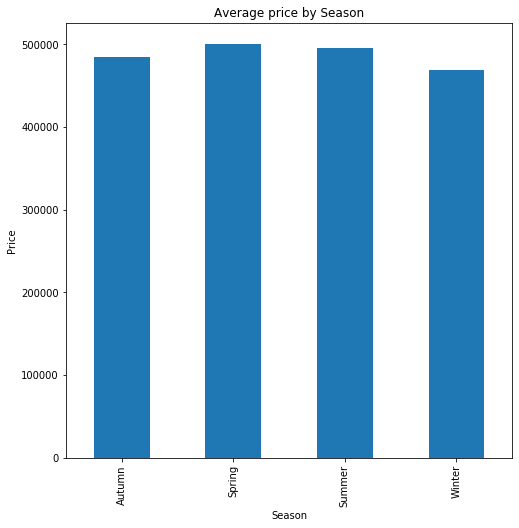

In [35]:
fig, ax = plt.subplots(figsize=(8,8))
df_temp = df_housing.groupby('season')['price'].mean().plot.bar()
plt.xlabel('Season')
plt.ylabel('Price')
plt.title('Average price by Season')
plt.show()

Text(0, 0.5, 'Count')

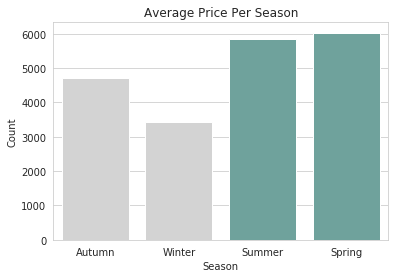

In [36]:
# define palette to highlight best months to buy house
custompalette = {season: "#66aaa2" if (season == 'Summer' or season == 'Spring' ) else "lightgrey" \
                 for season in df_housing['season'].unique()}

with sns.axes_style("whitegrid"):
    sns.countplot(x = df_housing['season'], palette = custompalette, data = df_housing)
plt.title('Average Price Per Season')
plt.xlabel('Season')
plt.ylabel('Count')

Using seasons instead of months makes it easier to see when is better to buy a house. Based on the previous graphs we can say that best time to buy a house is during the months of winter, which are: December, January and February. February being the best option out of them. 
The second best season will be Autumn, which includes September,October,November. November being the best option. 


# Question 2
## How does location affect house prices? 

I will try to answer this question using EDA 

In [37]:
df_housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20022 entries, 0 to 21596
Data columns (total 23 columns):
id               20022 non-null int64
date             20022 non-null datetime64[ns]
price            20022 non-null float64
bedrooms         20022 non-null int64
bathrooms        20022 non-null int64
sqft_living      20022 non-null int64
sqft_lot         20022 non-null int64
floors           20022 non-null int64
waterfront       20022 non-null int64
view             20022 non-null int64
condition        20022 non-null int64
grade            20022 non-null int64
sqft_above       20022 non-null int64
sqft_basement    20022 non-null float64
yr_built         20022 non-null int64
yr_renovated     20022 non-null float64
zipcode          20022 non-null int64
lat              20022 non-null float64
long             20022 non-null float64
sqft_living15    20022 non-null int64
sqft_lot15       20022 non-null int64
month            20022 non-null int64
season           20022 non-null obje

In [38]:
df_housing.groupby('zipcode')['price'].mean().sort_values( ascending = False).head()

zipcode
98039    1.144643e+06
98040    9.526905e+05
98004    9.510744e+05
98112    8.514943e+05
98109    7.739240e+05
Name: price, dtype: float64

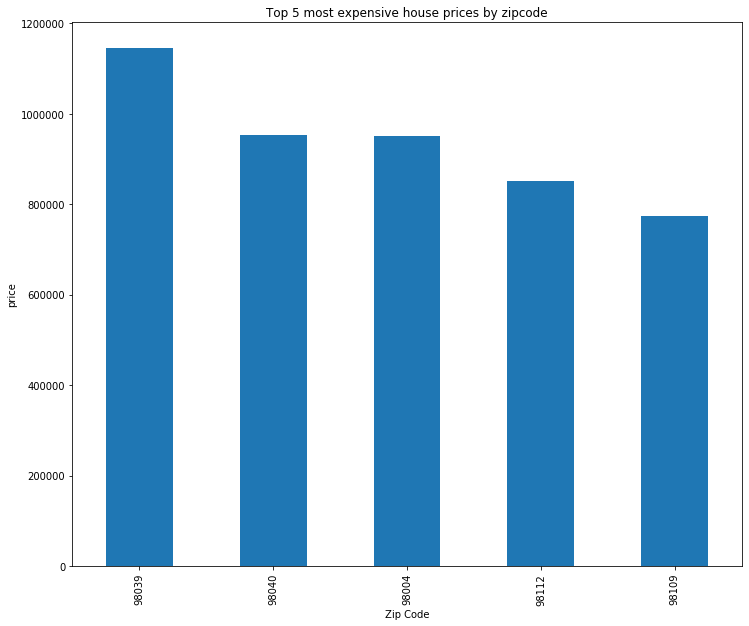

In [39]:
fig, ax = plt.subplots(figsize = (12, 10))
df_housing.groupby('zipcode')['price'].mean().sort_values(ascending= False).head().plot.bar()
plt.xlabel('Zip Code')
plt.ylabel('price')
plt.title('Top 5 most expensive house prices by zipcode')
plt.show()

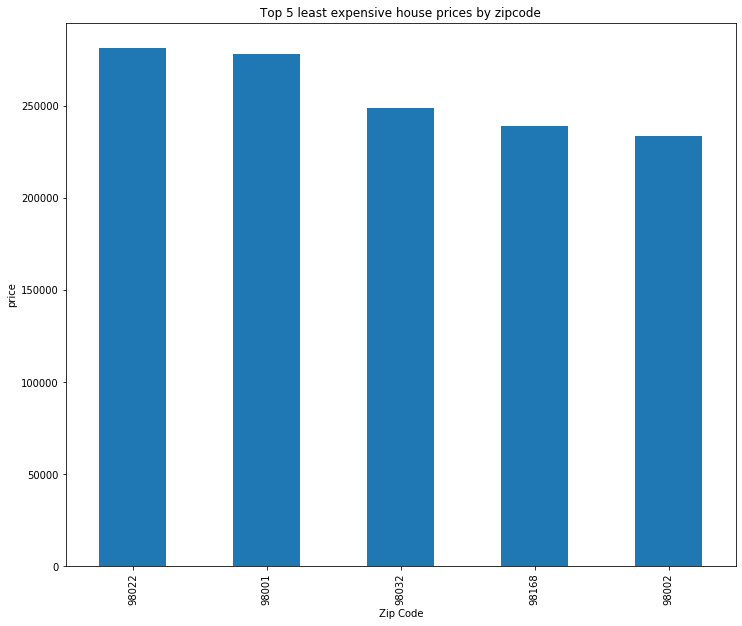

In [40]:
fig, ax = plt.subplots(figsize = (12, 10))
df_housing.groupby('zipcode')['price'].mean().sort_values(ascending= False).tail().plot.bar()
plt.xlabel('Zip Code')
plt.ylabel('price')
plt.title('Top 5 least expensive house prices by zipcode')
plt.show()

Based on these two charts the average prices for the most expensive postcodes reach over 2 million mark. However on the least expensive reach over 250,000. this leds me to conclude that there is a big difference on price when based on postcodes(Location).



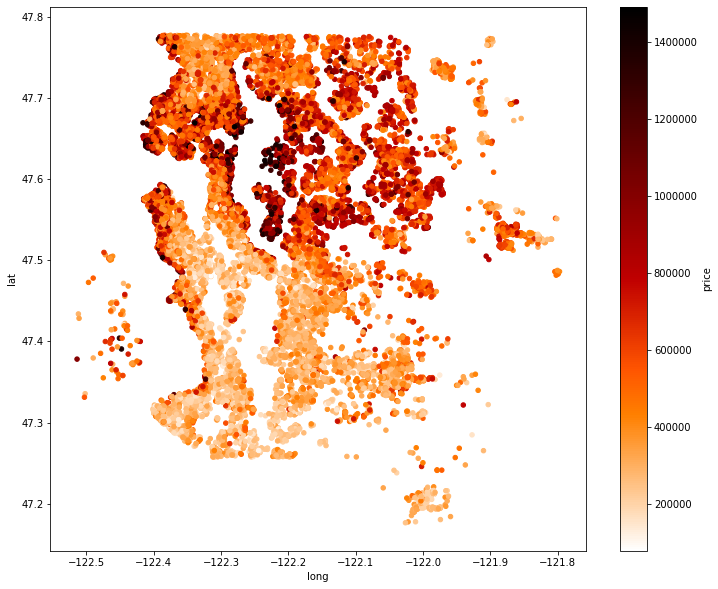

In [41]:
df_housing.plot(kind='scatter', x='long', y='lat', figsize =(12,10), c= 'price', 
                cmap ='gist_heat_r', colorbar = True, sharex=False)
plt.show()

There is a big difference in House price depending on the location. It is visible that house prices are higher at north than south, with prices ranging from 1.4 Million to 800.000. Also we can see that Houses with waterfront are more expensive as well, hence the most expensive location will be Mercer Island, Bellevue and Sammamish

Exploring further waterfront

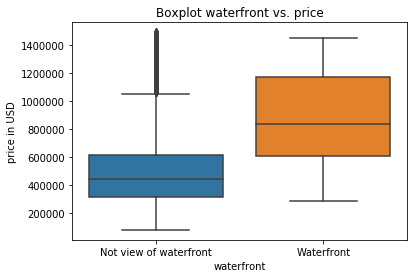

In [42]:
# Plot boxplot of waterfront 
sns.boxplot(x = df_housing['waterfront'], y = df_housing['price'])
plt.title("Boxplot waterfront vs. price")
plt.ylabel("price in USD")
plt.xticks(np.arange(2), ('Not view of waterfront', 'Waterfront'))
plt.show()

# Question 3
## What features affect price the most? 

I will start with sqft_living area. This is from the top of my head the most reliable feature affecting price

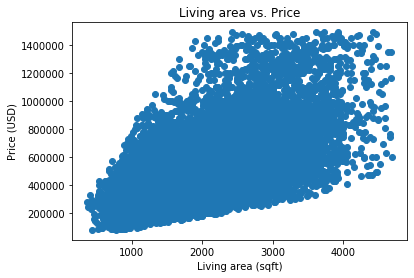

In [43]:
plt.scatter(x = list(df_housing['sqft_living']), y = list(df_housing['price']), data = df_housing)
plt.title('Living area vs. Price')
plt.xlabel('Living area (sqft)')
plt.ylabel('Price (USD)')
plt.show()

Now, let's have a look at other features

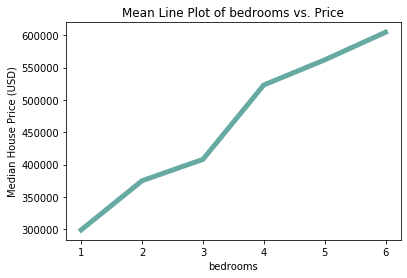

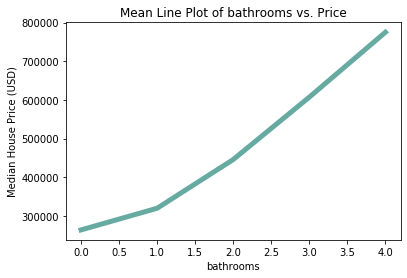

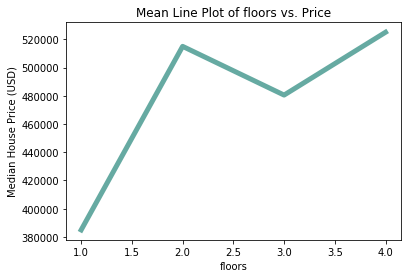

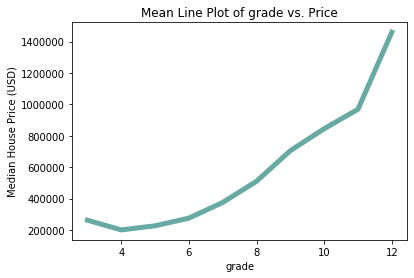

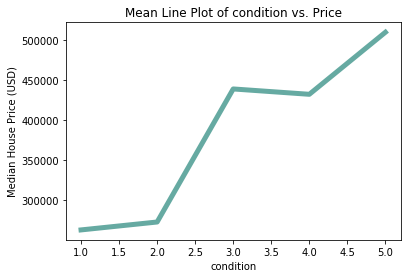

In [44]:
features = ['bedrooms', 'bathrooms', 'floors', 'grade', 'condition']

for f in features:
    temp_df = df_housing.groupby(df_housing[f])['price'].median().sort_values(ascending = False)
    temp_df = temp_df.reset_index()
    sns.lineplot(x = temp_df[f], y = temp_df['price'], lw = 5, color = '#66aaa2', data = temp_df)    
    plt.ylabel('Median House Price (USD)')
    plt.xlabel(f)
    plt.title(f"Mean Line Plot of {f} vs. Price")
    plt.show()


Overall, after sqft_living we can say that grade, bathrooms and bedrooms shows a good relationship with price, as when they increase so does price. Keeping an eye in this independent variables will be useful when creating the models. 

# Preparing data for Modelling

First I want to evaluate which variables will allow me to predict the price of the house.
To do this I need the variables to answer the following questions: 
1. is the variable related to the price? 
2. is the relationship strong?, how strong?
3. is the relationship linear? 
4. can we predict the house price based on that variable? 

I will be carrying out a correlation analysis. It will measure how much each variable is related to price. I will be looking for a correlation value to be bigger than 0.7.
Remember: the closer the value is to 1 the higher their correlation

### Checking for Multicollinearity

I need to check if the variables have any correlation between each other and deleting accordingly as this will have a negative impac in the model. 

Creating a corrleation heatmap

In [45]:
df_housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20022 entries, 0 to 21596
Data columns (total 23 columns):
id               20022 non-null int64
date             20022 non-null datetime64[ns]
price            20022 non-null float64
bedrooms         20022 non-null int64
bathrooms        20022 non-null int64
sqft_living      20022 non-null int64
sqft_lot         20022 non-null int64
floors           20022 non-null int64
waterfront       20022 non-null int64
view             20022 non-null int64
condition        20022 non-null int64
grade            20022 non-null int64
sqft_above       20022 non-null int64
sqft_basement    20022 non-null float64
yr_built         20022 non-null int64
yr_renovated     20022 non-null float64
zipcode          20022 non-null int64
lat              20022 non-null float64
long             20022 non-null float64
sqft_living15    20022 non-null int64
sqft_lot15       20022 non-null int64
month            20022 non-null int64
season           20022 non-null obje

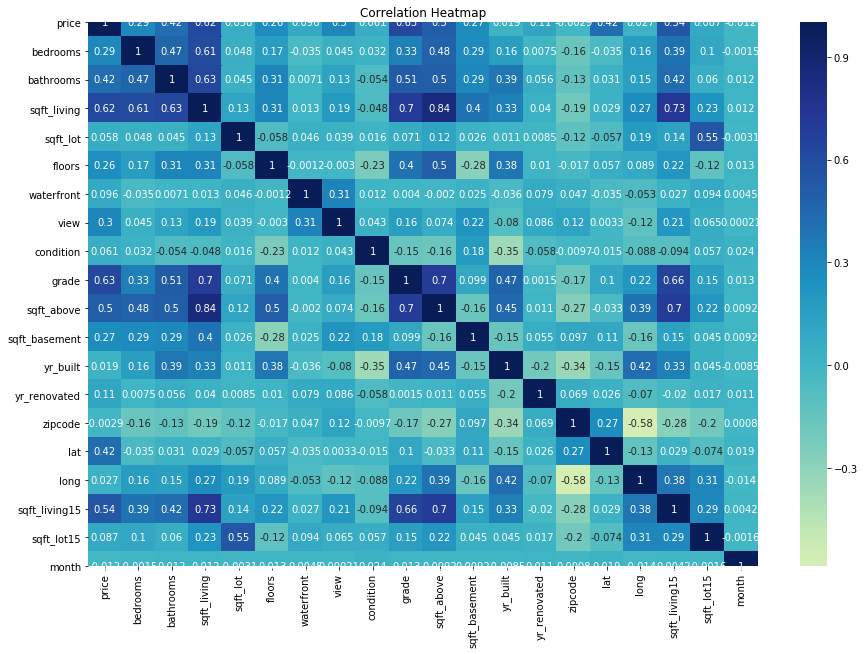

In [46]:
#Creating the correlation matrix
corr = df_housing.iloc[:,1:22].corr()
#Plotting the heatmap
plt.figure(figsize = (15,10))
sns.heatmap(corr, center = 0, cmap="YlGnBu", annot = True)
plt.title('Correlation Heatmap')
plt.show()

We can see that grade, sqft_above, sqft15 and bathrooms have a high correlation with sqft_living.

#### Identifying categorical data

I need to further inspect the data and separate continuos data from categorical data. 

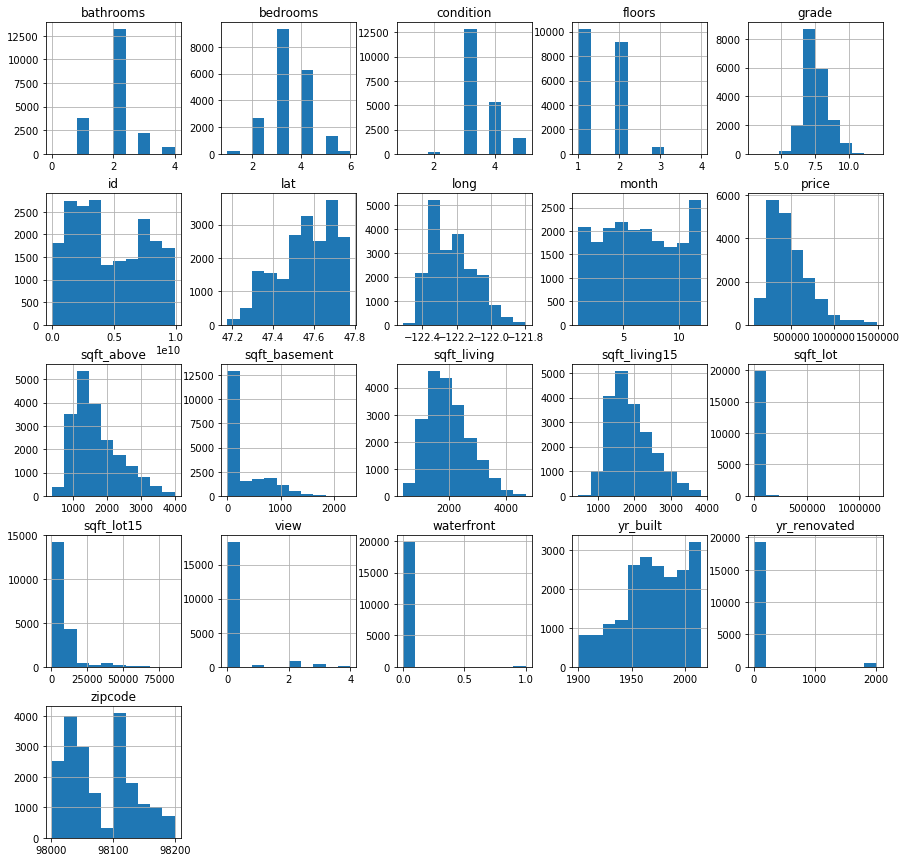

In [47]:
import warnings
warnings.filterwarnings('ignore')
fig = plt.figure(figsize = (15,15))
ax = fig.gca()
df_housing.hist(ax = ax);

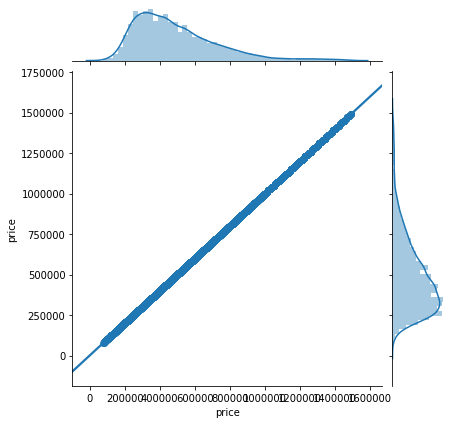

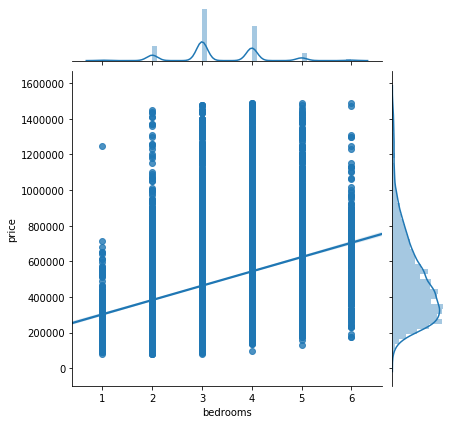

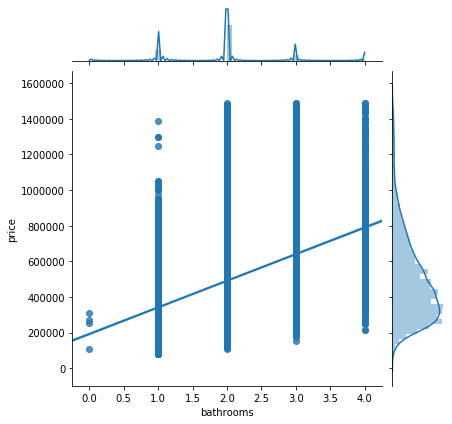

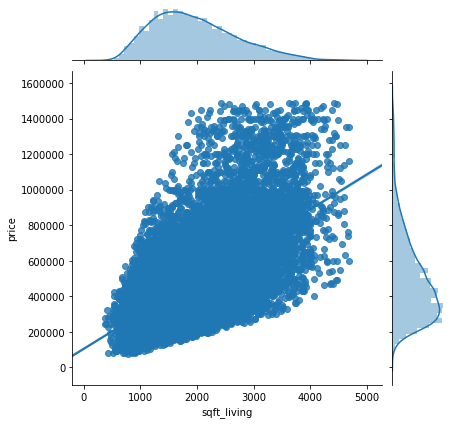

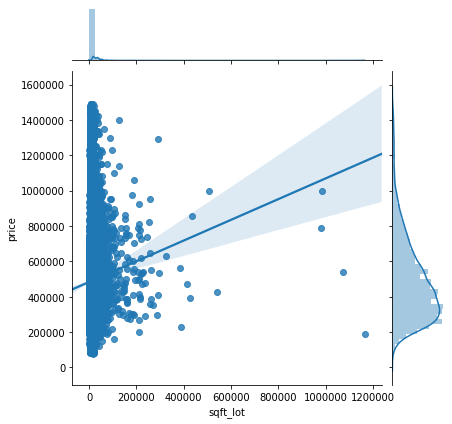

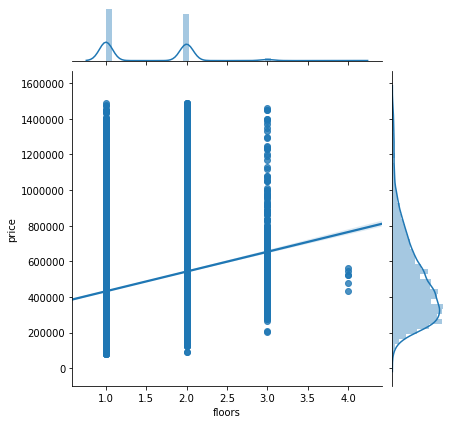

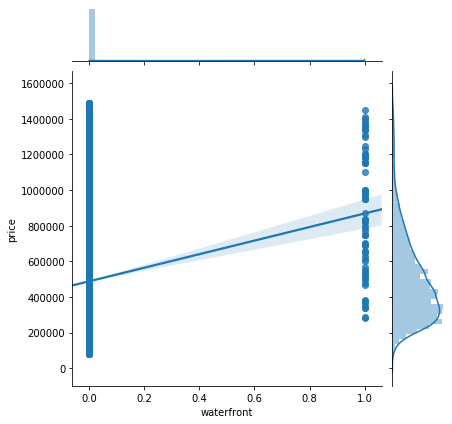

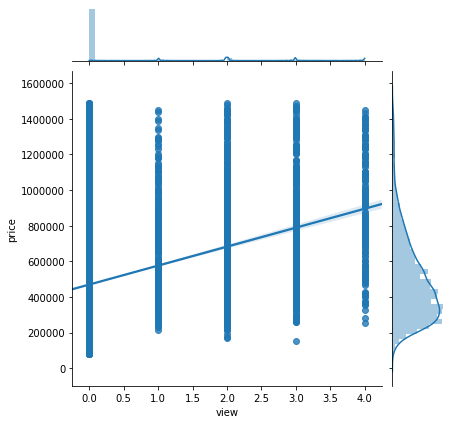

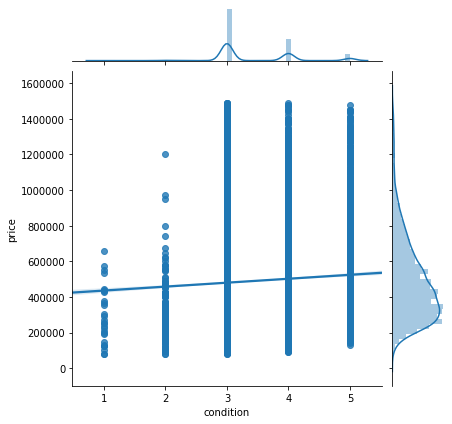

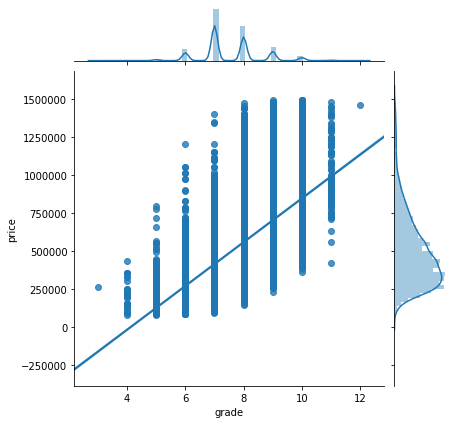

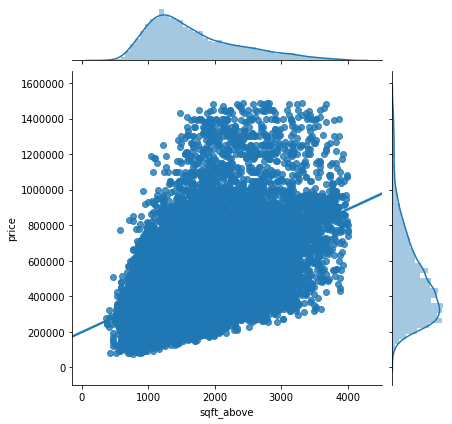

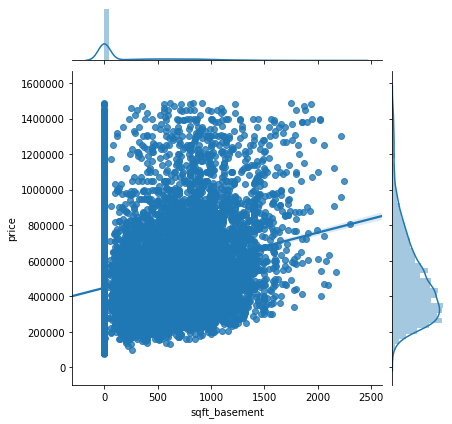

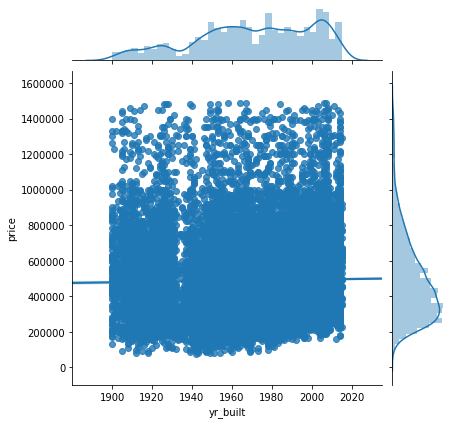

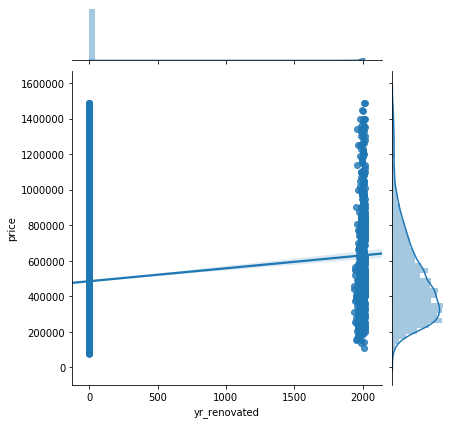

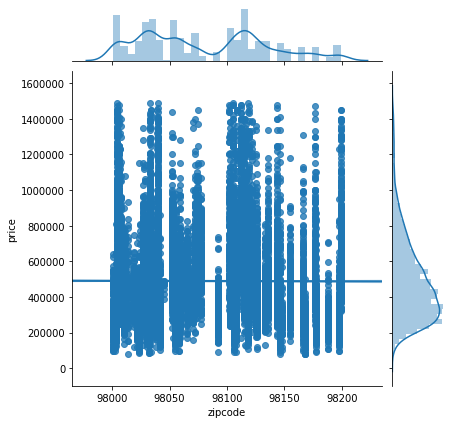

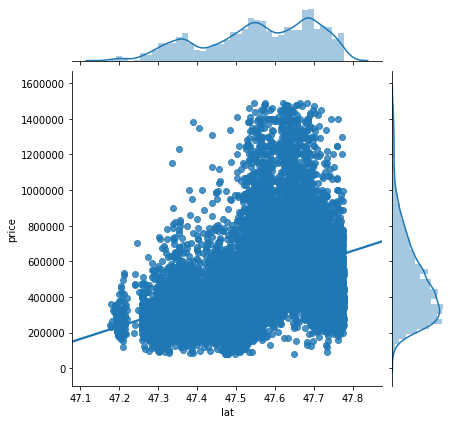

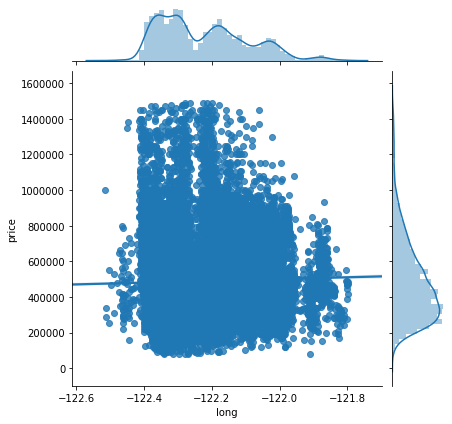

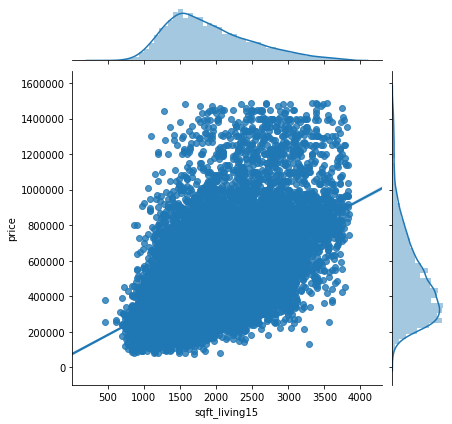

In [48]:
for column in df_housing.columns[2:20]:
    sns.jointplot(x = df_housing[column], y = df_housing['price'], kind = 'reg')

Based on the Visualizations above, I can tell that 
'bedrooms','bathrooms','floors','waterfront','view','condition','grade','yr_renovated','zipcode' are categorical variables. 
and 'sqft_living','sqft_living15','sqft_lot15','sqft_above' are continuos data. 
I will now separate this data to work on and then put them back together for the model.

### Dealing with categorical data

In [49]:
df_categorical = df_housing[['bedrooms','bathrooms','floors','waterfront','view','condition','grade','zipcode','price']]

In [50]:
df_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20022 entries, 0 to 21596
Data columns (total 9 columns):
bedrooms      20022 non-null int64
bathrooms     20022 non-null int64
floors        20022 non-null int64
waterfront    20022 non-null int64
view          20022 non-null int64
condition     20022 non-null int64
grade         20022 non-null int64
zipcode       20022 non-null int64
price         20022 non-null float64
dtypes: float64(1), int64(8)
memory usage: 2.2 MB


In [51]:
#labelencoder_cat = LabelEncoder()
#df_categorical[:, 0] = labelencoder_cat.fit_transform(df_categorical[:, 0])
#onehotencoder = OneHotEncoder(categorical_features = [0])
#df_categorical = onehotencoder.fit_transform(df_categorical).toarray()
#labelencoder_y = LabelEncoder()
#y = labelencoder_y.fit_transform(y)

In [52]:
# Define one-hot encoding function
def one_hot_encode(df, catcols):
    '''Returns df with dummy vars and drops original column'''
    
    # Create DataFrame with above columns
    dfonehot = df[catcols].astype('category')
    
    # Get dummy variables and drop first one to not create dependency
    dfonehot = pd.get_dummies(dfonehot, drop_first = True)
    
    # Recreate DataFrame with one-hot encoded variables
    df = pd.concat([df,dfonehot], axis=1)
    
    # Drop columns where we have done one-hot encoding
    df = df.drop(catcols, axis = 1)
        
    return df

In [53]:
df_categorical.columns[:8]

Index(['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'zipcode'],
      dtype='object')

In [54]:
df_categorical = one_hot_encode(df_categorical,df_categorical.columns[:8])
df_categorical


,price,bedrooms_2,bedrooms_3,bedrooms_4,bedrooms_5,bedrooms_6,bathrooms_1,bathrooms_2,bathrooms_3,bathrooms_4,...,zipcode_98146,zipcode_98148,zipcode_98155,zipcode_98166,zipcode_98168,zipcode_98177,zipcode_98178,zipcode_98188,zipcode_98198,zipcode_98199
0,221900.0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,538000.0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,180000.0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,604000.0,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,510000.0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
21593,400000.0,0,0,1,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
21594,402101.0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
21595,400000.0,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
for cols in df_categorical:
    print(cols)

price
bedrooms_2
bedrooms_3
bedrooms_4
bedrooms_5
bedrooms_6
bathrooms_1
bathrooms_2
bathrooms_3
bathrooms_4
floors_2
floors_3
floors_4
waterfront_1
view_1
view_2
view_3
view_4
condition_2
condition_3
condition_4
condition_5
grade_4
grade_5
grade_6
grade_7
grade_8
grade_9
grade_10
grade_11
grade_12
zipcode_98002
zipcode_98003
zipcode_98004
zipcode_98005
zipcode_98006
zipcode_98007
zipcode_98008
zipcode_98010
zipcode_98011
zipcode_98014
zipcode_98019
zipcode_98022
zipcode_98023
zipcode_98024
zipcode_98027
zipcode_98028
zipcode_98029
zipcode_98030
zipcode_98031
zipcode_98032
zipcode_98033
zipcode_98034
zipcode_98038
zipcode_98039
zipcode_98040
zipcode_98042
zipcode_98045
zipcode_98052
zipcode_98053
zipcode_98055
zipcode_98056
zipcode_98058
zipcode_98059
zipcode_98065
zipcode_98070
zipcode_98072
zipcode_98074
zipcode_98075
zipcode_98077
zipcode_98092
zipcode_98102
zipcode_98103
zipcode_98105
zipcode_98106
zipcode_98107
zipcode_98108
zipcode_98109
zipcode_98112
zipcode_98115
zipcode_98116


### Dealing with continuos data

In [56]:
df_continous = df_housing[['sqft_living','sqft_living15','sqft_lot15','sqft_above', 'price']]

In [57]:
df_continous.head()

,sqft_living,sqft_living15,sqft_lot15,sqft_above,price
0,1180,1340,5650,1180,221900.0
1,2570,1690,7639,2170,538000.0
2,770,2720,8062,770,180000.0
3,1960,1360,5000,1050,604000.0
4,1680,1800,7503,1680,510000.0


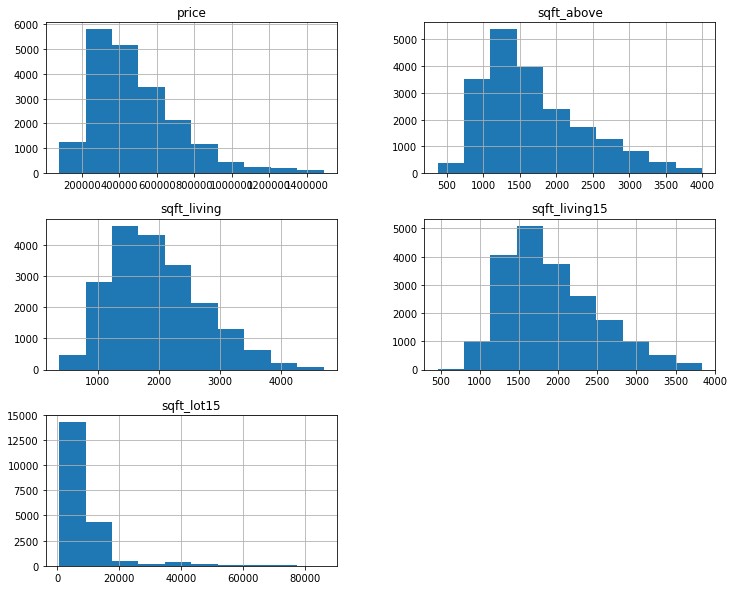

In [58]:
df_continous.hist(figsize=(12,10));

In [59]:

# Calculating the log for continuous columns

#data_log = (np.log1p(df_continous)).replace(-np.inf, 0)
#data_log.hist(figsize=(12,10))
#plt.show()

#### Linearity

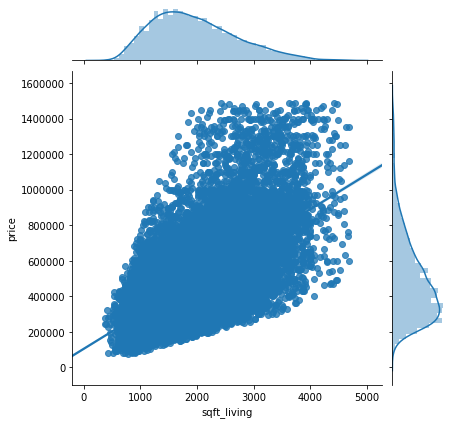

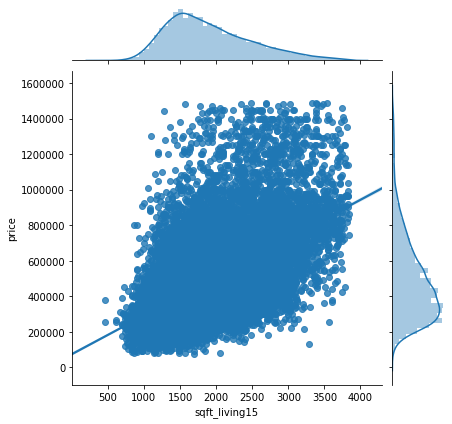

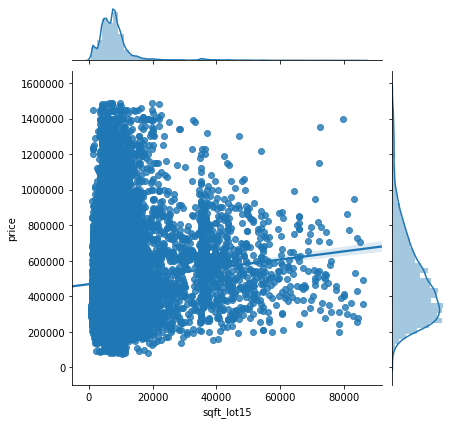

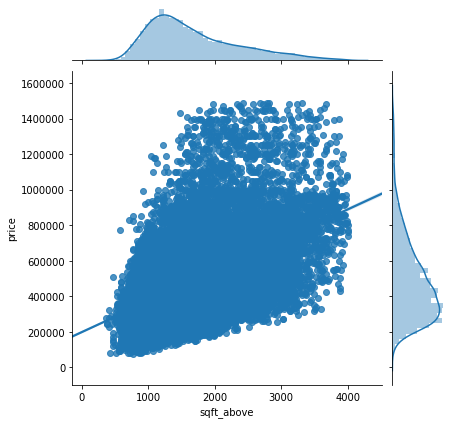

In [60]:
for column in df_continous.columns[:-1]:
    sns.jointplot(column, 'price', data=df_continous, kind='reg');

It is clearly stated that sqft_lot15 doesn't have a linear relationship with 'price'.

# Modelling

I will be creating 3 different models for this particular project. 

##### Model X

This model will use simple linear regression. I want to see if with the most specific feature I can get a decent R^2 Metric

##### Model Y 

This Model will use multiple linear regression. Increasing the amount of independent variables, to see if R^2 increases and to what point. 

##### Model Z 

This model will be the most complete and accurate. I will be aiming for the highest R^2 value and lowest Root Mean Squared Error. 


Both Models, Y and Z will have the features with a p-value lower than 0.05

## Train test split

My train test split will be a function so I can use it in the future as this will be needed for my three different models. 

In [61]:
def train_test(df):
    #splitting features x and target y 
    X = df.drop('price', axis = 1)
    y = df['price']
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test

## Calculating RMSE

RMSE is a piece of code that will be used many times, therefore I decided to make it a function as well. 

In [62]:
def RMSE_calc(X_train, X_test, y_train, y_test):
    # Create linear regression object
    linreg = LinearRegression()
    # Fit on training data
    linreg.fit(X_train, y_train)
    # Predicting for train and test data 
    y_hat_train = linreg.predict(X_train)

    y_hat_test = linreg.predict(X_test)

    # Calculating the residuals
    train_residuals = y_hat_train - y_train
    test_residuals = y_hat_test - y_test
    # Calculating mean Squared error and root mean squared error for train and test data
    train_mse = mean_squared_error(y_train, y_hat_train)
    test_mse = mean_squared_error(y_test, y_hat_test)
    train_rmse_score = np.sqrt(train_mse)
    test_rmse_score = np.sqrt(test_mse)
    return train_rmse_score, test_rmse_score




## Coefficient 

In [63]:

def coeff_cal(X,y):
    linreg = LinearRegression()
    # Fit on training data
    results = linreg.fit(X_train, y_train)

    # Create table with coefficients
    coeffdf = pd.DataFrame(data=linreg.coef_.reshape(1,-1), columns= X_train.columns).transpose()
    coeffdf = coeffdf.rename(columns = {0: "Coefficient"})
    coeffdf = coeffdf.reset_index()
    coeffdf = coeffdf.rename(columns = {'index': "Feature"})
    coeffdf['Coefficient'] = coeffdf['Coefficient'].map(lambda x : int(x))
    # Sort by values and print top 5
    return coeffdf


### Model X: Simple Linear Regression

I will be selecting:sqft_living for my base model. My base model will be only one independent variable. I will be refering back to the heat maps to check other possible variables affecting price that will fit in my multiple linear regression.

### Regression Sqft_living and Price

In [64]:
df_simple= df_housing[['sqft_living','price']]

In [65]:
df_simple.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20022 entries, 0 to 21596
Data columns (total 2 columns):
sqft_living    20022 non-null int64
price          20022 non-null float64
dtypes: float64(1), int64(1)
memory usage: 1.1 MB


### Inspecting Linearity

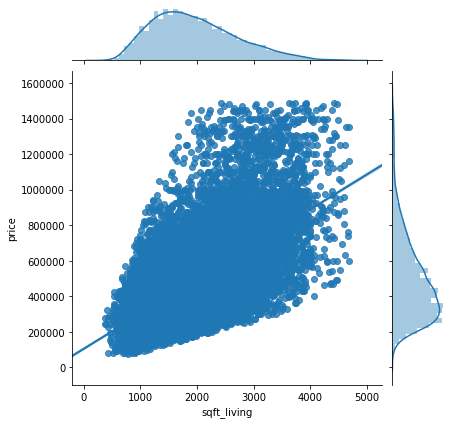

In [66]:
sns.jointplot(x = df_simple['sqft_living'], y = df_simple['price'], kind = 'reg')

### Simple linear regression

In [67]:
df_simple.head()

,sqft_living,price
0,1180,221900.0
1,2570,538000.0
2,770,180000.0
3,1960,604000.0
4,1680,510000.0


In [68]:
X_train = np.array(df_simple['sqft_living']).reshape(-1,1)
y_train = df_simple['price']

In [69]:
# Create model in OLS
X_int = sm.add_constant(X_train)
model = sm.OLS(y_train, X_int).fit()
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.381
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                 1.232e+04
Date:                Mon, 22 Jun 2020   Prob (F-statistic):               0.00
Time:                        14:32:56   Log-Likelihood:            -2.7130e+05
No. Observations:               20022   AIC:                         5.426e+05
Df Residuals:                   20020   BIC:                         5.426e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.049e+05   3707.033     28.308      0.000    9.77e+04    1.12e+05
x1           196.0021      1.766    111.000      0.000     192.541     199.463
==============================================================================
Omnibus:                     2858.257   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5240.609
Skew:                           0.920   Prob(JB):                         0.00
Kurtosis:                       4.702   Cond. No.                     5.93e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.93e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Using only one feature provided with a model that can only explain 38% of the data. This isn't bad at all, in fact it can almost explain 40% of the data

In [70]:
X_train, X_test, y_train, y_test = train_test(df_simple)
train_rmse_score, test_rmse_score = RMSE_calc(X_train, X_test, y_train, y_test)

Because is a Simple Linear Regression then we can visualize it 

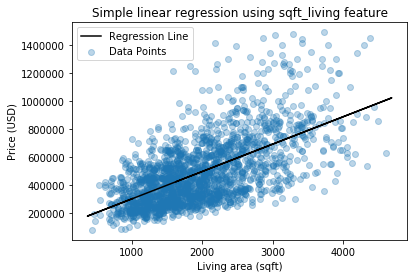

In [71]:
# Create visualisation of simple linear regression
linreg = LinearRegression()
# Get predictions
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_train)
# Plot data points
plt.scatter(x = X_train[:2000], y = y_train[:2000], alpha = 0.3, label = 'Data Points')
# Plot regression line
plt.plot(X_train, y_pred, color = 'Black', label = 'Regression Line')
plt.legend()
plt.title('Simple linear regression using sqft_living feature')
plt.xlabel('Living area (sqft)')
plt.ylabel('Price (USD)')
plt.show()


In [72]:
len(df_simple.columns)-1

1

We can appreciate that as the sqft living area increases, the model decreases in accuracy. 

I want to be able to check quickly on my different models, therefore I will be building a table where I can keep track of them

In [73]:
model_info = pd.DataFrame({'Model': [], 'Num of Features':[], 'R-squared':[],
                                'Adj R-squared':[], 'Train RMSE': [], 'Test RMSE':[]})


In [74]:
model_info.loc[0] = ['Simple Linear Regression', (len(df_simple.columns)-1), round(model.rsquared,3), round(model.rsquared_adj,3), int(train_rmse_score),int(test_rmse_score)]

In [75]:
model_info

,Model,Num of Features,R-squared,Adj R-squared,Train RMSE,Test RMSE
0,Simple Linear Regression,1.0,0.381,0.381,185753.0,184828.0


### Model Y: Multiple Linear Regression

#### Continous Data

I will be investigating continous and categorical data separetely. Then I will proceed to investigate further with my best initial findings against each other.   

In [76]:
X_train, X_test, y_train, y_test = train_test(df_continous)
X_int = sm.add_constant(X_train)
model = sm.OLS(y_train, X_int).fit()
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.409
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     2771.
Date:                Mon, 22 Jun 2020   Prob (F-statistic):               0.00
Time:                        14:32:56   Log-Likelihood:            -2.1666e+05
No. Observations:               16017   AIC:                         4.333e+05
Df Residuals:                   16012   BIC:                         4.334e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          4.618e+04   4878.498      9.466      0.000    3.66e+04    5.57e+04
sqft_living     174.7398      3.781     46.214      0.000     167.328     182.151
sqft_living15    97.8137      3.703     26.415      0.000      90.556     105.072
sqft_lot15       -2.3612      0.170    -13.919      0.000      -2.694      -2.029
sqft_above      -38.6749      3.916     -9.876      0.000     -46.351     -30.999
==============================================================================
Omnibus:                     2202.365   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4100.001
Skew:                           0.884   Prob(JB):                         0.00
Kurtosis:                       4.737   Cond. No.                     4.41e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.41e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

All p-values remain 0.00, however the condition number is very high, indicating a strong Multicollinearity. This model can also only explain 40% of the data. is not a big improvement on the previous model, but it is an improvement indeed.

In [77]:
RMSE_calc(X_train, X_test, y_train, y_test)

(181273.25370807564, 180906.3956918233)

In [78]:
model_info.loc[1] = ['Continous Multiple Linear Regression', (len(df_continous.columns)-1), round(model.rsquared,3), round(model.rsquared_adj,3), int(train_rmse_score),int(test_rmse_score)]

In [79]:
model_info

,Model,Num of Features,R-squared,Adj R-squared,Train RMSE,Test RMSE
0,Simple Linear Regression,1.0,0.381,0.381,185753.0,184828.0
1,Continous Multiple Linear Regression,4.0,0.409,0.409,185753.0,184828.0


#### Categorical data with bacward elimination

In [80]:
X_train, X_test, y_train, y_test = train_test(df_categorical)
X_int = sm.add_constant(X_train)
model = sm.OLS(y_train, X_int).fit()
summary = model.summary()
summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.790
Method:                 Least Squares   F-statistic:                     607.9
Date:                Mon, 22 Jun 2020   Prob (F-statistic):               0.00
Time:                        14:32:56   Log-Likelihood:            -2.0834e+05
No. Observations:               16017   AIC:                         4.169e+05
Df Residuals:                   15917   BIC:                         4.176e+05
Df Model:                          99                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          8.838e+04   1.24e+05      0.714      0.475   -1.54e+05    3.31e+05
bedrooms_2     2.383e+04   9364.818      2.545      0.011    5478.295    4.22e+04
bedrooms_3     5.923e+04   9378.991      6.315      0.000    4.08e+04    7.76e+04
bedrooms_4     9.817e+04   9522.056     10.309      0.000    7.95e+04    1.17e+05
bedrooms_5     1.146e+05      1e+04     11.429      0.000     9.5e+04    1.34e+05
bedrooms_6     1.176e+05   1.25e+04      9.407      0.000    9.31e+04    1.42e+05
bathrooms_1    2.772e+04   5.43e+04      0.511      0.610   -7.87e+04    1.34e+05
bathrooms_2    5.245e+04   5.43e+04      0.966      0.334    -5.4e+04    1.59e+05
bathrooms_3    9.595e+04   5.44e+04      1.765      0.078   -1.06e+04    2.03e+05
bathrooms_4    1.394e+05   5.45e+04      2.557      0.011    3.26e+04    2.46e+05
floors_2       1.566e+04   2103.914      7.443      0.000    1.15e+04    1.98e+04
floors_3      -8.984e+04   5684.121    -15.806      0.000   -1.01e+05   -7.87e+04
floors_4      -1.016e+05   4.86e+04     -2.090      0.037   -1.97e+05   -6304.687
waterfront_1   2.141e+05   1.72e+04     12.469      0.000     1.8e+05    2.48e+05
view_1         9.003e+04   7259.101     12.403      0.000    7.58e+04    1.04e+05
view_2         9.445e+04   4469.039     21.135      0.000    8.57e+04    1.03e+05
view_3         1.733e+05   6764.837     25.623      0.000     1.6e+05    1.87e+05
view_4         2.756e+05   1.09e+04     25.214      0.000    2.54e+05    2.97e+05
condition_2    4.387e+04   2.52e+04      1.740      0.082   -5545.161    9.33e+04
condition_3    7.584e+04   2.34e+04      3.246      0.001       3e+04    1.22e+05
condition_4    1.044e+05   2.34e+04      4.464      0.000    5.86e+04     1.5e+05
condition_5    1.447e+05   2.35e+04      6.148      0.000    9.85e+04    1.91e+05
grade_4       -1.037e+05   1.11e+05     -0.933      0.351   -3.22e+05    1.14e+05
grade_5       -1.255e+05   1.09e+05     -1.150      0.250    -3.4e+05    8.84e+04
grade_6       -1.092e+05   1.09e+05     -1.002      0.316   -3.23e+05    1.04e+05
grade_7       -6.824e+04   1.09e+05     -0.626      0.531   -2.82e+05    1.45e+05
grade_8        1.436e+04   1.09e+05      0.132      0.895   -1.99e+05    2.28e+05
grade_9        1.472e+05   1.09e+05      1.350      0.177   -6.65e+04    3.61e+05
grade_10        2.69e+05   1.09e+05      2.466      0.014    5.52e+04    4.83e+05
grade_11       3.836e+05    1.1e+05      3.492      0.000    1.68e+05    5.99e+05
grade_12       4.621e+05   1.54e+05      3.001      0.003     1.6e+05    7.64e+05
zipcode_98002 -1577.0443   1.08e+04     -0.146      0.884   -2.27e+04    1.95e+04
zipcode_98003 -5935.9503   9894.869     -0.600      0.549   -2.53e+04    1.35e+04
zipcode_98004  6.087e+05   1.07e+04     56.694      0.000    5.88e+05     6.3e+05
zipcode_98005  3.576e+05   1.22e+04     29.369   

Using categorical data improves my R-squared, it can explain 79% of the data. What I find more interesting is that the condition number is very low! A lot of the p-values are very high exceeding 0.05 by more more than double in some variables. Therefore I will be carrying out Backward Eliminiation. This is my base model for model Y

In [81]:
train_rmse_score, test_rmse_score = RMSE_calc(X_train, X_test, y_train, y_test)

In [82]:
model_info.loc[2] = ['Categorical Multiple Linear Regression Version A', (len(df_categorical.columns)-1), round(model.rsquared,3), round(model.rsquared_adj,3), int(train_rmse_score),int(test_rmse_score)]

In [83]:
model_info


,Model,Num of Features,R-squared,Adj R-squared,Train RMSE,Test RMSE
0,Simple Linear Regression,1.0,0.381,0.381,185753.0,184828.0
1,Continous Multiple Linear Regression,4.0,0.409,0.409,185753.0,184828.0
2,Categorical Multiple Linear Regression Version A,99.0,0.791,0.790,107844.0,110181.0


#### 1st Backward elimination

#### Filtering p_values

In [84]:
# Filtering p-values higher than 0.05
def filter_pval(md):
    p_values = md.pvalues
    new_cols = [ x for x in p_values[p_values < 0.05].index.tolist() if not x == 'Intercept']
    new_cols = [x.replace('[T.1]', '').replace('[T.1.0]', '') for x in new_cols]
    new_cols.append('price')
    return new_cols

In [85]:
new_cols = filter_pval(model)

In [86]:
df_categorical2 = df_categorical[new_cols]

In [87]:
X_train, X_test, y_train, y_test = train_test(df_categorical2)
X_int = sm.add_constant(X_train)
model = sm.OLS(y_train, X_int).fit()
summary = model.summary()
summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     494.1
Date:                Mon, 22 Jun 2020   Prob (F-statistic):               0.00
Time:                        14:32:57   Log-Likelihood:            -2.1081e+05
No. Observations:               16017   AIC:                         4.218e+05
Df Residuals:                   15935   BIC:                         4.224e+05
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.933e+04   1.45e+04      2.021      0.043     883.118    5.78e+04
bedrooms_2     4.416e+04   1.06e+04      4.147      0.000    2.33e+04     6.5e+04
bedrooms_3     1.077e+05   1.05e+04     10.292      0.000    8.72e+04    1.28e+05
bedrooms_4     1.759e+05   1.06e+04     16.615      0.000    1.55e+05    1.97e+05
bedrooms_5     1.991e+05   1.11e+04     17.862      0.000    1.77e+05    2.21e+05
bedrooms_6     1.871e+05   1.41e+04     13.240      0.000    1.59e+05    2.15e+05
bathrooms_4     1.07e+05   5615.337     19.059      0.000     9.6e+04    1.18e+05
floors_2       6.194e+04   2334.114     26.537      0.000    5.74e+04    6.65e+04
floors_3      -6977.4508   6419.602     -1.087      0.277   -1.96e+04    5605.693
floors_4       1.299e+04   5.66e+04      0.229      0.819    -9.8e+04    1.24e+05
waterfront_1   1.915e+05      2e+04      9.571      0.000    1.52e+05    2.31e+05
view_1         1.283e+05   8424.083     15.232      0.000    1.12e+05    1.45e+05
view_2         1.327e+05   5161.344     25.716      0.000    1.23e+05    1.43e+05
view_3         2.457e+05   7782.638     31.566      0.000     2.3e+05    2.61e+05
view_4         3.549e+05   1.27e+04     27.992      0.000     3.3e+05     3.8e+05
condition_3    7.859e+04   1.07e+04      7.339      0.000    5.76e+04    9.96e+04
condition_4    8.991e+04   1.08e+04      8.324      0.000    6.87e+04    1.11e+05
condition_5    1.292e+05   1.12e+04     11.524      0.000    1.07e+05    1.51e+05
grade_10       2.278e+05   5514.797     41.315      0.000    2.17e+05    2.39e+05
grade_11       3.321e+05   1.56e+04     21.330      0.000    3.02e+05    3.63e+05
grade_12       3.165e+05   1.27e+05      2.497      0.013     6.8e+04    5.65e+05
zipcode_98004  6.511e+05   1.04e+04     62.812      0.000    6.31e+05    6.71e+05
zipcode_98005  4.344e+05   1.23e+04     35.337      0.000     4.1e+05    4.58e+05
zipcode_98006   3.49e+05   7474.006     46.702      0.000    3.34e+05    3.64e+05
zipcode_98007  2.903e+05   1.22e+04     23.814      0.000    2.66e+05    3.14e+05
zipcode_98008  2.638e+05   9144.097     28.848      0.000    2.46e+05    2.82e+05
zipcode_98010  9.665e+04   1.56e+04      6.209      0.000    6.61e+04    1.27e+05
zipcode_98011  1.886e+05   1.06e+04     17.727      0.000    1.68e+05    2.09e+05
zipcode_98014    1.6e+05   1.59e+04     10.036      0.000    1.29e+05    1.91e+05
zipcode_98019  1.243e+05    1.1e+04     11.327      0.000    1.03e+05    1.46e+05
zipcode_98023 -7380.5961   7039.948     -1.048      0.294   -2.12e+04    6418.496
zipcode_98024  1.616e+05   2.12e+04      7.608      0.000     1.2e+05    2.03e+05
zipcode_98027  2.392e+05   8105.710     29.513      0.000    2.23e+05    2.55e+05
zipcode_98028   1.62e+05   8905.584     18.196      0.000    1.45e+05    1.79e+05
zipcode_98029  2.628e+05   8820.519     29.791   

My r-squared has dropped to 0.71. Meaning the model can only explain 71% of the data. A big drop from the base model. However conditonal number is also lower and less p-values exceed 0.05

In [88]:
train_rmse_score, test_rmse_score = RMSE_calc(X_train, X_test, y_train, y_test)

In [89]:
model_info.loc[3] = ['Categorical Multiple Linear Regression Version B', (len(df_categorical2.columns)-1), round(model.rsquared,3), round(model.rsquared_adj,3), int(train_rmse_score),int(test_rmse_score)]

In [90]:
model_info

,Model,Num of Features,R-squared,Adj R-squared,Train RMSE,Test RMSE
0,Simple Linear Regression,1.0,0.381,0.381,185753.0,184828.0
1,Continous Multiple Linear Regression,4.0,0.409,0.409,185753.0,184828.0
2,Categorical Multiple Linear Regression Version A,99.0,0.791,0.790,107844.0,110181.0
3,Categorical Multiple Linear Regression Version B,81.0,0.715,0.714,125839.0,129864.0


#### 2nd Backward elimination

In [91]:
new_cols = filter_pval(model)

In [92]:
df_categorical3 = df_categorical[new_cols[1:]]

In [93]:
X_train, X_test, y_train, y_test = train_test(df_categorical3)
X_int = sm.add_constant(X_train)
model = sm.OLS(y_train, X_int).fit()
summary = model.summary()
summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     540.8
Date:                Mon, 22 Jun 2020   Prob (F-statistic):               0.00
Time:                        14:32:57   Log-Likelihood:            -2.1081e+05
No. Observations:               16017   AIC:                         4.218e+05
Df Residuals:                   15942   BIC:                         4.224e+05
Df Model:                          74                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           3.03e+04   1.44e+04      2.108      0.035    2129.214    5.85e+04
bedrooms_2     4.399e+04   1.06e+04      4.132      0.000    2.31e+04    6.49e+04
bedrooms_3     1.071e+05   1.05e+04     10.244      0.000    8.66e+04    1.28e+05
bedrooms_4     1.753e+05   1.06e+04     16.585      0.000    1.55e+05    1.96e+05
bedrooms_5     1.988e+05   1.11e+04     17.843      0.000    1.77e+05    2.21e+05
bedrooms_6     1.867e+05   1.41e+04     13.215      0.000    1.59e+05    2.14e+05
bathrooms_4    1.068e+05   5610.592     19.028      0.000    9.58e+04    1.18e+05
floors_2       6.257e+04   2272.020     27.539      0.000    5.81e+04     6.7e+04
waterfront_1   1.909e+05      2e+04      9.552      0.000    1.52e+05     2.3e+05
view_1         1.283e+05   8420.960     15.232      0.000    1.12e+05    1.45e+05
view_2         1.328e+05   5151.807     25.787      0.000    1.23e+05    1.43e+05
view_3         2.456e+05   7778.337     31.580      0.000     2.3e+05    2.61e+05
view_4         3.548e+05   1.27e+04     27.989      0.000     3.3e+05     3.8e+05
condition_3    7.842e+04   1.07e+04      7.330      0.000    5.74e+04    9.94e+04
condition_4     8.99e+04   1.08e+04      8.328      0.000    6.87e+04    1.11e+05
condition_5    1.295e+05   1.12e+04     11.562      0.000    1.08e+05    1.51e+05
grade_10       2.275e+05   5510.346     41.279      0.000    2.17e+05    2.38e+05
grade_11       3.315e+05   1.56e+04     21.301      0.000    3.01e+05    3.62e+05
grade_12       3.163e+05   1.27e+05      2.496      0.013    6.79e+04    5.65e+05
zipcode_98004  6.504e+05   1.02e+04     63.644      0.000     6.3e+05     6.7e+05
zipcode_98005  4.339e+05   1.22e+04     35.645      0.000     4.1e+05    4.58e+05
zipcode_98006  3.484e+05   7275.472     47.893      0.000    3.34e+05    3.63e+05
zipcode_98007  2.897e+05   1.21e+04     24.002      0.000    2.66e+05    3.13e+05
zipcode_98008  2.633e+05   8979.366     29.324      0.000    2.46e+05    2.81e+05
zipcode_98010  9.606e+04   1.55e+04      6.209      0.000    6.57e+04    1.26e+05
zipcode_98011   1.88e+05   1.05e+04     17.917      0.000    1.67e+05    2.09e+05
zipcode_98014  1.594e+05   1.58e+04     10.062      0.000    1.28e+05     1.9e+05
zipcode_98019  1.236e+05   1.08e+04     11.403      0.000    1.02e+05    1.45e+05
zipcode_98024  1.611e+05   2.12e+04      7.614      0.000     1.2e+05    2.03e+05
zipcode_98027  2.384e+05   7917.325     30.106      0.000    2.23e+05    2.54e+05
zipcode_98028  1.615e+05   8732.857     18.490      0.000    1.44e+05    1.79e+05
zipcode_98029  2.619e+05   8651.667     30.273      0.000    2.45e+05    2.79e+05
zipcode_98033  3.771e+05   7517.687     50.164      0.000    3.62e+05    3.92e+05
zipcode_98034  1.897e+05   6500.583     29.175      0.000    1.77e+05    2.02e+05
zipcode_98038  4.617e+04   6453.593      7.154   

In [94]:
train_rmse_score, test_rmse_score = RMSE_calc(X_train, X_test, y_train, y_test)

In [95]:
model_info.loc[4] = ['Categorical Multiple Linear Regression Version C', (len(df_categorical3.columns)-1), round(model.rsquared,3), round(model.rsquared_adj,3), int(train_rmse_score),int(test_rmse_score)]
model_info

,Model,Num of Features,R-squared,Adj R-squared,Train RMSE,Test RMSE
0,Simple Linear Regression,1.0,0.381,0.381,185753.0,184828.0
1,Continous Multiple Linear Regression,4.0,0.409,0.409,185753.0,184828.0
2,Categorical Multiple Linear Regression Version A,99.0,0.791,0.790,107844.0,110181.0
3,Categorical Multiple Linear Regression Version B,81.0,0.715,0.714,125839.0,129864.0
4,Categorical Multiple Linear Regression Version C,74.0,0.715,0.714,125859.0,129856.0


### Continous and Categorical Data with backward elimination

I will be using both dfs now. It's good to note that I am using my df_categorical2, which already has some variables taken off to improve the model

In [96]:
for i in df_continous.columns:
    print(i)

sqft_living
sqft_living15
sqft_lot15
sqft_above
price


In [97]:
df_continous = df_continous.drop('price', axis =1 )
df_final = pd.concat([df_continous, df_categorical3], axis =1)

In [98]:
X_train, X_test, y_train, y_test = train_test(df_final)
X_int = sm.add_constant(X_train)
model = sm.OLS(y_train, X_int).fit()
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.817
Method:                 Least Squares   F-statistic:                     914.8
Date:                Mon, 22 Jun 2020   Prob (F-statistic):               0.00
Time:                        14:32:57   Log-Likelihood:            -2.0725e+05
No. Observations:               16017   AIC:                         4.147e+05
Df Residuals:                   15938   BIC:                         4.153e+05
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.284e+05   1.19e+04    -10.797      0.000   -1.52e+05   -1.05e+05
sqft_living     105.0790      2.537     41.417      0.000     100.106     110.052
sqft_living15    40.4304      2.295     17.617      0.000      35.932      44.929
sqft_lot15        0.6496      0.110      5.887      0.000       0.433       0.866
sqft_above       42.4912      2.760     15.394      0.000      37.081      47.902
bedrooms_2     6277.8556   8550.344      0.734      0.463   -1.05e+04     2.3e+04
bedrooms_3     9134.4276   8472.206      1.078      0.281   -7472.052    2.57e+04
bedrooms_4     7084.1511   8708.954      0.813      0.416   -9986.382    2.42e+04
bedrooms_5    -8068.8886   9290.176     -0.869      0.385   -2.63e+04    1.01e+04
bedrooms_6    -3.817e+04   1.17e+04     -3.267      0.001   -6.11e+04   -1.53e+04
bathrooms_4    3.962e+04   4584.108      8.642      0.000    3.06e+04    4.86e+04
floors_2       2709.9418   2162.990      1.253      0.210   -1529.762    6949.646
waterfront_1   2.146e+05    1.6e+04     13.390      0.000    1.83e+05    2.46e+05
view_1         6.477e+04   6811.215      9.509      0.000    5.14e+04    7.81e+04
view_2         7.705e+04   4202.089     18.335      0.000    6.88e+04    8.53e+04
view_3         1.551e+05   6345.038     24.442      0.000    1.43e+05    1.68e+05
view_4         2.529e+05   1.03e+04     24.640      0.000    2.33e+05    2.73e+05
condition_3    4.231e+04   8580.854      4.931      0.000    2.55e+04    5.91e+04
condition_4    6.172e+04   8653.503      7.133      0.000    4.48e+04    7.87e+04
condition_5    1.024e+05   8990.684     11.386      0.000    8.47e+04     1.2e+05
grade_10       1.009e+05   4630.506     21.789      0.000    9.18e+04     1.1e+05
grade_11       1.762e+05   1.26e+04     13.994      0.000    1.52e+05    2.01e+05
grade_12       1.816e+05   1.01e+05      1.789      0.074   -1.74e+04    3.81e+05
zipcode_98004   5.95e+05   8258.310     72.048      0.000    5.79e+05    6.11e+05
zipcode_98005  3.541e+05   9806.101     36.105      0.000    3.35e+05    3.73e+05
zipcode_98006  2.827e+05   5926.522     47.701      0.000    2.71e+05    2.94e+05
zipcode_98007  2.685e+05   9675.622     27.754      0.000     2.5e+05    2.88e+05
zipcode_98008  2.535e+05   7198.416     35.212      0.000    2.39e+05    2.68e+05
zipcode_98010  7.283e+04   1.25e+04      5.846      0.000    4.84e+04    9.72e+04
zipcode_98011  1.403e+05   8436.198     16.629      0.000    1.24e+05    1.57e+05
zipcode_98014  1.167e+05   1.28e+04      9.129      0.000    9.16e+04    1.42e+05
zipcode_98019  8.466e+04   8695.644      9.736      0.000    6.76e+04    1.02e+05
zipcode_98024  1.326e+05   1.71e+04      7.739      0.000     9.9e+04    1.66e+05
zipcode_98027  1.878e+05   6421.827     29.248      0.000    1.75e+05       2e+05
zipcode_98028  1.286e+05   7008.891     18.346   

In [99]:
train_rmse_score, test_rmse_score = RMSE_calc(X_train, X_test, y_train, y_test)

In [100]:
model_info.loc[5] = ['Multiple Linear Regression version A', (len(df_final.columns)-1), round(model.rsquared,3), round(model.rsquared_adj,3), int(train_rmse_score),int(test_rmse_score)]

#### 1st Backward elimination

In [101]:
new_cols = filter_pval(model)

In [102]:
df_final2 = df_final[new_cols[1:]]

In [103]:
X_train, X_test, y_train, y_test = train_test(df_final2)
X_int = sm.add_constant(X_train)
model = sm.OLS(y_train, X_int).fit()
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     989.2
Date:                Mon, 22 Jun 2020   Prob (F-statistic):               0.00
Time:                        14:32:58   Log-Likelihood:            -2.0727e+05
No. Observations:               16017   AIC:                         4.147e+05
Df Residuals:                   15944   BIC:                         4.152e+05
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.204e+05   9116.244    -13.211      0.000   -1.38e+05   -1.03e+05
sqft_living     102.0695      2.281     44.753      0.000      97.599     106.540
sqft_living15    40.5450      2.290     17.701      0.000      36.055      45.035
sqft_lot15        0.6410      0.110      5.843      0.000       0.426       0.856
sqft_above       45.2649      2.408     18.795      0.000      40.544      49.985
bedrooms_6    -4.296e+04   7799.904     -5.508      0.000   -5.83e+04   -2.77e+04
bathrooms_4    3.817e+04   4564.592      8.362      0.000    2.92e+04    4.71e+04
waterfront_1   2.151e+05    1.6e+04     13.425      0.000    1.84e+05    2.47e+05
view_1         6.509e+04   6812.432      9.554      0.000    5.17e+04    7.84e+04
view_2         7.743e+04   4199.322     18.438      0.000    6.92e+04    8.57e+04
view_3         1.559e+05   6340.706     24.581      0.000    1.43e+05    1.68e+05
view_4          2.53e+05   1.03e+04     24.647      0.000    2.33e+05    2.73e+05
condition_3    4.366e+04   8562.171      5.099      0.000    2.69e+04    6.04e+04
condition_4    6.274e+04   8634.203      7.266      0.000    4.58e+04    7.97e+04
condition_5    1.037e+05   8970.681     11.559      0.000    8.61e+04    1.21e+05
grade_10       1.014e+05   4597.889     22.064      0.000    9.24e+04     1.1e+05
grade_11       1.769e+05   1.26e+04     14.072      0.000    1.52e+05    2.02e+05
zipcode_98004  5.942e+05   8257.435     71.959      0.000    5.78e+05     6.1e+05
zipcode_98005  3.535e+05   9804.167     36.056      0.000    3.34e+05    3.73e+05
zipcode_98006  2.823e+05   5928.529     47.611      0.000    2.71e+05    2.94e+05
zipcode_98007   2.67e+05   9676.695     27.591      0.000    2.48e+05    2.86e+05
zipcode_98008  2.521e+05   7185.983     35.083      0.000    2.38e+05    2.66e+05
zipcode_98010  7.335e+04   1.25e+04      5.884      0.000    4.89e+04    9.78e+04
zipcode_98011  1.398e+05   8438.760     16.566      0.000    1.23e+05    1.56e+05
zipcode_98014  1.169e+05   1.28e+04      9.156      0.000    9.19e+04    1.42e+05
zipcode_98019  8.514e+04   8691.393      9.796      0.000    6.81e+04    1.02e+05
zipcode_98024  1.319e+05   1.72e+04      7.689      0.000    9.83e+04    1.66e+05
zipcode_98027  1.882e+05   6409.500     29.359      0.000    1.76e+05    2.01e+05
zipcode_98028  1.288e+05   7013.198     18.367      0.000    1.15e+05    1.43e+05
zipcode_98029  2.371e+05   6928.480     34.226      0.000    2.24e+05    2.51e+05
zipcode_98033   3.47e+05   6042.452     57.435      0.000    3.35e+05    3.59e+05
zipcode_98034  1.889e+05   5213.172     36.243      0.000    1.79e+05    1.99e+05
zipcode_98038  2.207e+04   5174.577      4.266      0.000    1.19e+04    3.22e+04
zipcode_98039  7.812e+05   3.06e+04     25.546      0.000    7.21e+05    8.41e+05
zipcode_98040  4.794e+05   8271.096     57.961   

In [104]:
train_rmse_score, test_rmse_score = RMSE_calc(X_train, X_test, y_train, y_test)

In [105]:
model_info.loc[6] = ['Multiple Linear Regression Version B', (len(df_final2.columns)-1), round(model.rsquared,3), round(model.rsquared_adj,3), int(train_rmse_score),int(test_rmse_score)]

In [106]:
test_rmse_score

101520.76160838119

In [107]:
model_info

,Model,Num of Features,R-squared,Adj R-squared,Train RMSE,Test RMSE
0,Simple Linear Regression,1.0,0.381,0.381,185753.0,184828.0
1,Continous Multiple Linear Regression,4.0,0.409,0.409,185753.0,184828.0
2,Categorical Multiple Linear Regression Version A,99.0,0.791,0.790,107844.0,110181.0
3,Categorical Multiple Linear Regression Version B,81.0,0.715,0.714,125839.0,129864.0
4,Categorical Multiple Linear Regression Version C,74.0,0.715,0.714,125859.0,129856.0
5,Multiple Linear Regression version A,78.0,0.817,0.817,100760.0,101362.0
6,Multiple Linear Regression Version B,72.0,0.817,0.816,100854.0,101520.0


In [108]:
new_cols = filter_pval(model)
df_final3 = df_final[new_cols[1:]]
X_train, X_test, y_train, y_test = train_test(df_final3)
X_int = sm.add_constant(X_train)
model = sm.OLS(y_train, X_int).fit()
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.816
Method:                 Least Squares   F-statistic:                     989.2
Date:                Mon, 22 Jun 2020   Prob (F-statistic):               0.00
Time:                        14:32:58   Log-Likelihood:            -2.0727e+05
No. Observations:               16017   AIC:                         4.147e+05
Df Residuals:                   15944   BIC:                         4.152e+05
Df Model:                          72                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -1.204e+05   9116.244    -13.211      0.000   -1.38e+05   -1.03e+05
sqft_living     102.0695      2.281     44.753      0.000      97.599     106.540
sqft_living15    40.5450      2.290     17.701      0.000      36.055      45.035
sqft_lot15        0.6410      0.110      5.843      0.000       0.426       0.856
sqft_above       45.2649      2.408     18.795      0.000      40.544      49.985
bedrooms_6    -4.296e+04   7799.904     -5.508      0.000   -5.83e+04   -2.77e+04
bathrooms_4    3.817e+04   4564.592      8.362      0.000    2.92e+04    4.71e+04
waterfront_1   2.151e+05    1.6e+04     13.425      0.000    1.84e+05    2.47e+05
view_1         6.509e+04   6812.432      9.554      0.000    5.17e+04    7.84e+04
view_2         7.743e+04   4199.322     18.438      0.000    6.92e+04    8.57e+04
view_3         1.559e+05   6340.706     24.581      0.000    1.43e+05    1.68e+05
view_4          2.53e+05   1.03e+04     24.647      0.000    2.33e+05    2.73e+05
condition_3    4.366e+04   8562.171      5.099      0.000    2.69e+04    6.04e+04
condition_4    6.274e+04   8634.203      7.266      0.000    4.58e+04    7.97e+04
condition_5    1.037e+05   8970.681     11.559      0.000    8.61e+04    1.21e+05
grade_10       1.014e+05   4597.889     22.064      0.000    9.24e+04     1.1e+05
grade_11       1.769e+05   1.26e+04     14.072      0.000    1.52e+05    2.02e+05
zipcode_98004  5.942e+05   8257.435     71.959      0.000    5.78e+05     6.1e+05
zipcode_98005  3.535e+05   9804.167     36.056      0.000    3.34e+05    3.73e+05
zipcode_98006  2.823e+05   5928.529     47.611      0.000    2.71e+05    2.94e+05
zipcode_98007   2.67e+05   9676.695     27.591      0.000    2.48e+05    2.86e+05
zipcode_98008  2.521e+05   7185.983     35.083      0.000    2.38e+05    2.66e+05
zipcode_98010  7.335e+04   1.25e+04      5.884      0.000    4.89e+04    9.78e+04
zipcode_98011  1.398e+05   8438.760     16.566      0.000    1.23e+05    1.56e+05
zipcode_98014  1.169e+05   1.28e+04      9.156      0.000    9.19e+04    1.42e+05
zipcode_98019  8.514e+04   8691.393      9.796      0.000    6.81e+04    1.02e+05
zipcode_98024  1.319e+05   1.72e+04      7.689      0.000    9.83e+04    1.66e+05
zipcode_98027  1.882e+05   6409.500     29.359      0.000    1.76e+05    2.01e+05
zipcode_98028  1.288e+05   7013.198     18.367      0.000    1.15e+05    1.43e+05
zipcode_98029  2.371e+05   6928.480     34.226      0.000    2.24e+05    2.51e+05
zipcode_98033   3.47e+05   6042.452     57.435      0.000    3.35e+05    3.59e+05
zipcode_98034  1.889e+05   5213.172     36.243      0.000    1.79e+05    1.99e+05
zipcode_98038  2.207e+04   5174.577      4.266      0.000    1.19e+04    3.22e+04
zipcode_98039  7.812e+05   3.06e+04     25.546      0.000    7.21e+05    8.41e+05
zipcode_98040  4.794e+05   8271.096     57.961   

In [109]:
train_rmse_score, test_rmse_score = RMSE_calc(X_train, X_test, y_train, y_test)

model_info.loc[7] = ['Multiple Linear Regression Version C', (len(df_final3.columns)-1), round(model.rsquared,3), round(model.rsquared_adj,3), int(train_rmse_score),int(test_rmse_score)]
model_info

,Model,Num of Features,R-squared,Adj R-squared,Train RMSE,Test RMSE
0,Simple Linear Regression,1.0,0.381,0.381,185753.0,184828.0
1,Continous Multiple Linear Regression,4.0,0.409,0.409,185753.0,184828.0
2,Categorical Multiple Linear Regression Version A,99.0,0.791,0.790,107844.0,110181.0
3,Categorical Multiple Linear Regression Version B,81.0,0.715,0.714,125839.0,129864.0
4,Categorical Multiple Linear Regression Version C,74.0,0.715,0.714,125859.0,129856.0
5,Multiple Linear Regression version A,78.0,0.817,0.817,100760.0,101362.0
6,Multiple Linear Regression Version B,72.0,0.817,0.816,100854.0,101520.0
7,Multiple Linear Regression Version C,72.0,0.817,0.816,100854.0,101520.0


In [110]:
coeff = coeff_cal(X_train,y_train)
coeff.sort_values("Coefficient", axis = 0, ascending = False)

,Feature,Coefficient
32,zipcode_98039,781151
16,zipcode_98004,594197
54,zipcode_98112,524361
33,zipcode_98040,479401
53,zipcode_98109,472991
...,...,...
0,sqft_living,102
3,sqft_above,45
1,sqft_living15,40
2,sqft_lot15,0


In [132]:
coeff.head(12).sort_values("Coefficient", axis = 0, ascending = False)

,Feature,Coefficient
8,view_4,244744
4,waterfront_1,215927
11,grade_11,191822
7,view_3,149438
10,grade_10,111845
6,view_2,73427
5,view_1,59842
9,condition_5,49706
2,bathrooms_4,33021
3,floors_2,16359


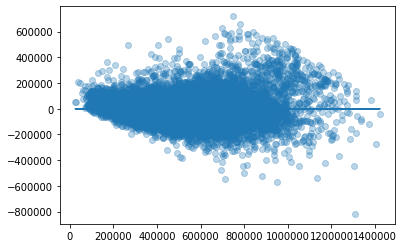

In [111]:
# Scatterplot of predictions
plt.scatter(model.predict(X_int), model.resid, alpha = 0.3)
plt.plot(model.predict(X_int), [0 for i in range(len(X_train))])
plt.show()

### Model Z 

I will be selecting the one of the variables in continous data. 
I will then be exploring whether it makes a difference to have only one instead of 4 variables. As they do have strong Multicollinearity between each other. 


I will only be using 'Sqft_living' from the continous dataset as it has the highest correlation with price 

In [112]:
df_continous = df_continous[['sqft_living15', 'sqft_living']]
df_modelz = pd.concat([df_continous, df_categorical3], axis =1)

In [113]:
X_train, X_test, y_train, y_test = train_test(df_modelz)
X_int = sm.add_constant(X_test)
model = sm.OLS(y_test, X_int).fit()
summary = model.summary()
summary


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.817
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     233.5
Date:                Mon, 22 Jun 2020   Prob (F-statistic):               0.00
Time:                        14:32:59   Log-Likelihood:                -51834.
No. Observations:                4005   AIC:                         1.038e+05
Df Residuals:                    3929   BIC:                         1.043e+05
Df Model:                          75                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -9.434e+04   2.45e+04     -3.852      0.000   -1.42e+05   -4.63e+04
sqft_living15    48.5528      4.682     10.370      0.000      39.373      57.733
sqft_living     142.4169      4.079     34.919      0.000     134.421     150.413
bedrooms_2     1.357e+04   1.82e+04      0.746      0.456   -2.21e+04    4.93e+04
bedrooms_3     1.344e+04    1.8e+04      0.745      0.456   -2.19e+04    4.88e+04
bedrooms_4    -3425.7544   1.85e+04     -0.185      0.853   -3.97e+04    3.28e+04
bedrooms_5     -2.71e+04   1.95e+04     -1.390      0.165   -6.53e+04    1.11e+04
bedrooms_6    -4.286e+04   2.41e+04     -1.779      0.075   -9.01e+04    4385.714
bathrooms_4    2.194e+04   9309.058      2.356      0.019    3684.448    4.02e+04
floors_2       1.592e+04   3843.642      4.141      0.000    8380.583    2.35e+04
waterfront_1   2.519e+05   3.39e+04      7.434      0.000    1.85e+05    3.18e+05
view_1         8.517e+04   1.43e+04      5.956      0.000    5.71e+04    1.13e+05
view_2         8.093e+04   9079.771      8.914      0.000    6.31e+04    9.87e+04
view_3         1.126e+05   1.15e+04      9.828      0.000    9.02e+04    1.35e+05
view_4         1.683e+05   1.77e+04      9.527      0.000    1.34e+05    2.03e+05
condition_3    4149.4446   1.64e+04      0.252      0.801   -2.81e+04    3.64e+04
condition_4    1.995e+04   1.66e+04      1.202      0.229   -1.26e+04    5.25e+04
condition_5    6.042e+04   1.73e+04      3.485      0.000    2.64e+04    9.44e+04
grade_10       8.812e+04   9647.961      9.134      0.000    6.92e+04    1.07e+05
grade_11       1.831e+05   2.06e+04      8.898      0.000    1.43e+05    2.23e+05
grade_12       1.274e-08   6.48e-10     19.681      0.000    1.15e-08     1.4e-08
zipcode_98004  5.786e+05   1.64e+04     35.364      0.000    5.47e+05    6.11e+05
zipcode_98005  3.398e+05   1.74e+04     19.491      0.000    3.06e+05    3.74e+05
zipcode_98006  2.773e+05   1.26e+04     22.016      0.000    2.53e+05    3.02e+05
zipcode_98007   2.63e+05   2.17e+04     12.131      0.000     2.2e+05    3.05e+05
zipcode_98008  2.362e+05   1.42e+04     16.597      0.000    2.08e+05    2.64e+05
zipcode_98010   4.78e+04   2.67e+04      1.792      0.073   -4482.374       1e+05
zipcode_98011  1.307e+05   1.68e+04      7.779      0.000    9.78e+04    1.64e+05
zipcode_98014  7.478e+04   2.58e+04      2.899      0.004    2.42e+04    1.25e+05
zipcode_98019  6.705e+04   2.12e+04      3.158      0.002    2.54e+04    1.09e+05
zipcode_98024  1.533e+05   2.67e+04      5.751      0.000    1.01e+05    2.06e+05
zipcode_98027  1.797e+05   1.28e+04     14.026      0.000    1.55e+05    2.05e+05
zipcode_98028  1.283e+05   1.41e+04      9.123      0.000    1.01e+05    1.56e+05
zipcode_98029  2.278e+05   1.25e+04     18.150      0.000    2.03e+05    2.52e+05
zipcode_98033  3.156e+05   1.21e+04     26.084   

In [114]:

train_rmse_score, test_rmse_score = RMSE_calc(X_train, X_test, y_train, y_test)
model_info.loc[8] = ['Model Z Multiple Linear Regression Version A', (len(df_modelz.columns)-1), round(model.rsquared,3), round(model.rsquared_adj,3), int(train_rmse_score),int(test_rmse_score)]
model_info


,Model,Num of Features,R-squared,Adj R-squared,Train RMSE,Test RMSE
0,Simple Linear Regression,1.0,0.381,0.381,185753.0,184828.0
1,Continous Multiple Linear Regression,4.0,0.409,0.409,185753.0,184828.0
2,Categorical Multiple Linear Regression Version A,99.0,0.791,0.790,107844.0,110181.0
3,Categorical Multiple Linear Regression Version B,81.0,0.715,0.714,125839.0,129864.0
4,Categorical Multiple Linear Regression Version C,74.0,0.715,0.714,125859.0,129856.0
5,Multiple Linear Regression version A,78.0,0.817,0.817,100760.0,101362.0
6,Multiple Linear Regression Version B,72.0,0.817,0.816,100854.0,101520.0
7,Multiple Linear Regression Version C,72.0,0.817,0.816,100854.0,101520.0
8,Model Z Multiple Linear Regression Version A,76.0,0.817,0.813,101626.0,102703.0


#### 1st Backward Elimination

In [115]:
new_cols = filter_pval(model)
df_modelz2 = df_modelz[new_cols[1:]]
X_train, X_test, y_train, y_test = train_test(df_modelz2)
X_int = sm.add_constant(X_train)
model = sm.OLS(y_train, X_int).fit()
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     1069.
Date:                Mon, 22 Jun 2020   Prob (F-statistic):               0.00
Time:                        14:32:59   Log-Likelihood:            -2.0753e+05
No. Observations:               16017   AIC:                         4.152e+05
Df Residuals:                   15952   BIC:                         4.157e+05
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -4.915e+04   3666.604    -13.406      0.000   -5.63e+04    -4.2e+04
sqft_living15    48.1232      2.268     21.214      0.000      43.677      52.570
sqft_living     126.7881      1.737     73.002      0.000     123.384     130.192
bathrooms_4     3.27e+04   4618.125      7.081      0.000    2.37e+04    4.18e+04
floors_2       1.635e+04   1870.705      8.740      0.000    1.27e+04       2e+04
waterfront_1    2.16e+05   1.63e+04     13.277      0.000    1.84e+05    2.48e+05
view_1         5.993e+04   6911.567      8.670      0.000    4.64e+04    7.35e+04
view_2         7.316e+04   4255.587     17.191      0.000    6.48e+04    8.15e+04
view_3         1.495e+05   6421.814     23.277      0.000    1.37e+05    1.62e+05
view_4         2.448e+05   1.04e+04     23.519      0.000    2.24e+05    2.65e+05
condition_5    4.973e+04   3048.502     16.314      0.000    4.38e+04    5.57e+04
grade_10        1.12e+05   4621.450     24.239      0.000    1.03e+05    1.21e+05
grade_11       1.921e+05   1.27e+04     15.070      0.000    1.67e+05    2.17e+05
grade_12       2.019e+05   1.03e+05      1.957      0.050    -359.461    4.04e+05
zipcode_98004  5.874e+05   8347.208     70.371      0.000    5.71e+05    6.04e+05
zipcode_98005  3.494e+05   9922.935     35.212      0.000     3.3e+05    3.69e+05
zipcode_98006  2.721e+05   5940.220     45.806      0.000     2.6e+05    2.84e+05
zipcode_98007  2.609e+05   9781.290     26.677      0.000    2.42e+05     2.8e+05
zipcode_98008  2.475e+05   7258.906     34.098      0.000    2.33e+05    2.62e+05
zipcode_98011  1.268e+05   8522.958     14.873      0.000     1.1e+05    1.43e+05
zipcode_98014  1.195e+05   1.29e+04      9.292      0.000    9.43e+04    1.45e+05
zipcode_98019   7.77e+04   8777.806      8.852      0.000    6.05e+04    9.49e+04
zipcode_98024  1.416e+05   1.72e+04      8.230      0.000    1.08e+05    1.75e+05
zipcode_98027  1.807e+05   6412.068     28.181      0.000    1.68e+05    1.93e+05
zipcode_98028  1.183e+05   7073.117     16.719      0.000    1.04e+05    1.32e+05
zipcode_98029  2.254e+05   6989.425     32.248      0.000    2.12e+05    2.39e+05
zipcode_98033  3.405e+05   6077.876     56.029      0.000    3.29e+05    3.52e+05
zipcode_98034  1.774e+05   5228.105     33.927      0.000    1.67e+05    1.88e+05
zipcode_98039  7.769e+05   3.11e+04     25.012      0.000    7.16e+05    8.38e+05
zipcode_98040  4.721e+05   8359.216     56.471      0.000    4.56e+05    4.88e+05
zipcode_98052  2.502e+05   5126.087     48.810      0.000     2.4e+05     2.6e+05
zipcode_98053  2.338e+05   6746.434     34.654      0.000    2.21e+05    2.47e+05
zipcode_98056  8.089e+04   6021.478     13.434      0.000    6.91e+04    9.27e+04
zipcode_98058  2.945e+04   5702.594      5.164      0.000    1.83e+04    4.06e+04
zipcode_98059  8.142e+04   5755.391     14.147   

In [116]:
train_rmse_score, test_rmse_score = RMSE_calc(X_train, X_test, y_train, y_test)

model_info.loc[9] = ['Model Z Multiple Linear Regression Version B', (len(df_modelz2.columns)-1), round(model.rsquared,3), round(model.rsquared_adj,3), int(train_rmse_score),int(test_rmse_score)]
model_info


,Model,Num of Features,R-squared,Adj R-squared,Train RMSE,Test RMSE
0,Simple Linear Regression,1.0,0.381,0.381,185753.0,184828.0
1,Continous Multiple Linear Regression,4.0,0.409,0.409,185753.0,184828.0
2,Categorical Multiple Linear Regression Version A,99.0,0.791,0.790,107844.0,110181.0
3,Categorical Multiple Linear Regression Version B,81.0,0.715,0.714,125839.0,129864.0
4,Categorical Multiple Linear Regression Version C,74.0,0.715,0.714,125859.0,129856.0
5,Multiple Linear Regression version A,78.0,0.817,0.817,100760.0,101362.0
6,Multiple Linear Regression Version B,72.0,0.817,0.816,100854.0,101520.0
7,Multiple Linear Regression Version C,72.0,0.817,0.816,100854.0,101520.0
8,Model Z Multiple Linear Regression Version A,76.0,0.817,0.813,101626.0,102703.0
9,Model Z Multiple Linear Regression Version B,64.0,0.811,0.810,102518.0,103187.0


#### 2nd Backward Elimination

In [117]:
new_cols = filter_pval(model)
df_modelz3 = df_modelz2[new_cols[1:]]
X_train, X_test, y_train, y_test = train_test(df_modelz3)
X_int = sm.add_constant(X_train)
model = sm.OLS(y_train, X_int).fit()
summary = model.summary()
summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.811
Model:                            OLS   Adj. R-squared:                  0.810
Method:                 Least Squares   F-statistic:                     1086.
Date:                Mon, 22 Jun 2020   Prob (F-statistic):               0.00
Time:                        14:32:59   Log-Likelihood:            -2.0753e+05
No. Observations:               16017   AIC:                         4.152e+05
Df Residuals:                   15953   BIC:                         4.157e+05
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -4.923e+04   3666.709    -13.427      0.000   -5.64e+04    -4.2e+04
sqft_living15    48.1588      2.269     21.229      0.000      43.712      52.605
sqft_living     126.7884      1.737     72.996      0.000     123.384     130.193
bathrooms_4    3.302e+04   4615.650      7.154      0.000     2.4e+04    4.21e+04
floors_2       1.636e+04   1870.863      8.744      0.000    1.27e+04       2e+04
waterfront_1   2.159e+05   1.63e+04     13.273      0.000    1.84e+05    2.48e+05
view_1         5.984e+04   6912.051      8.658      0.000    4.63e+04    7.34e+04
view_2         7.343e+04   4253.744     17.262      0.000    6.51e+04    8.18e+04
view_3         1.494e+05   6422.352     23.268      0.000    1.37e+05    1.62e+05
view_4         2.447e+05   1.04e+04     23.515      0.000    2.24e+05    2.65e+05
condition_5    4.971e+04   3048.741     16.304      0.000    4.37e+04    5.57e+04
grade_10       1.118e+05   4621.017     24.204      0.000    1.03e+05    1.21e+05
grade_11       1.918e+05   1.27e+04     15.049      0.000    1.67e+05    2.17e+05
zipcode_98004  5.874e+05   8347.947     70.364      0.000    5.71e+05    6.04e+05
zipcode_98005  3.494e+05   9923.811     35.207      0.000     3.3e+05    3.69e+05
zipcode_98006  2.721e+05   5940.738     45.798      0.000     2.6e+05    2.84e+05
zipcode_98007  2.609e+05   9782.157     26.675      0.000    2.42e+05     2.8e+05
zipcode_98008  2.475e+05   7259.548     34.093      0.000    2.33e+05    2.62e+05
zipcode_98011  1.268e+05   8523.713     14.871      0.000     1.1e+05    1.43e+05
zipcode_98014  1.195e+05   1.29e+04      9.291      0.000    9.43e+04    1.45e+05
zipcode_98019  7.768e+04   8778.579      8.849      0.000    6.05e+04    9.49e+04
zipcode_98024  1.416e+05   1.72e+04      8.227      0.000    1.08e+05    1.75e+05
zipcode_98027  1.807e+05   6412.630     28.176      0.000    1.68e+05    1.93e+05
zipcode_98028  1.183e+05   7073.744     16.717      0.000    1.04e+05    1.32e+05
zipcode_98029  2.254e+05   6990.037     32.243      0.000    2.12e+05    2.39e+05
zipcode_98033  3.405e+05   6078.405     56.021      0.000    3.29e+05    3.52e+05
zipcode_98034  1.774e+05   5228.569     33.923      0.000    1.67e+05    1.88e+05
zipcode_98039  7.769e+05   3.11e+04     25.009      0.000    7.16e+05    8.38e+05
zipcode_98040  4.732e+05   8338.090     56.756      0.000    4.57e+05     4.9e+05
zipcode_98052  2.502e+05   5126.534     48.803      0.000     2.4e+05     2.6e+05
zipcode_98053  2.338e+05   6747.031     34.650      0.000    2.21e+05    2.47e+05
zipcode_98056  8.088e+04   6022.010     13.431      0.000    6.91e+04    9.27e+04
zipcode_98058  2.946e+04   5703.099      5.165      0.000    1.83e+04    4.06e+04
zipcode_98059  8.141e+04   5755.899     14.144      0.000    7.01e+04    9.27e+04
zipcode_98065  9.073e+04   7366.204     12.317   

In [118]:
train_rmse_score, test_rmse_score = RMSE_calc(X_train, X_test, y_train, y_test)

model_info.loc[10] = ['Model Z Multiple Linear Regression Version C', (len(df_modelz3.columns)-1), round(model.rsquared,3), round(model.rsquared_adj,3), int(train_rmse_score),int(test_rmse_score)]
model_info


,Model,Num of Features,R-squared,Adj R-squared,Train RMSE,Test RMSE
0,Simple Linear Regression,1.0,0.381,0.381,185753.0,184828.0
1,Continous Multiple Linear Regression,4.0,0.409,0.409,185753.0,184828.0
2,Categorical Multiple Linear Regression Version A,99.0,0.791,0.790,107844.0,110181.0
3,Categorical Multiple Linear Regression Version B,81.0,0.715,0.714,125839.0,129864.0
4,Categorical Multiple Linear Regression Version C,74.0,0.715,0.714,125859.0,129856.0
5,Multiple Linear Regression version A,78.0,0.817,0.817,100760.0,101362.0
6,Multiple Linear Regression Version B,72.0,0.817,0.816,100854.0,101520.0
7,Multiple Linear Regression Version C,72.0,0.817,0.816,100854.0,101520.0
8,Model Z Multiple Linear Regression Version A,76.0,0.817,0.813,101626.0,102703.0
9,Model Z Multiple Linear Regression Version B,64.0,0.811,0.810,102518.0,103187.0


In [133]:
coeff = coeff_cal(X_train,y_train)
coeff.sort_values("Coefficient", axis = 0, ascending = False)

,Feature,Coefficient
26,zipcode_98039,776936
12,zipcode_98004,587395
46,zipcode_98112,501506
27,zipcode_98040,473232
45,zipcode_98109,449462
...,...,...
2,bathrooms_4,33021
31,zipcode_98058,29455
3,floors_2,16359
1,sqft_living,126


In [134]:
coeff.head(12).sort_values("Coefficient", axis = 0, ascending = False)

,Feature,Coefficient
8,view_4,244744
4,waterfront_1,215927
11,grade_11,191822
7,view_3,149438
10,grade_10,111845
6,view_2,73427
5,view_1,59842
9,condition_5,49706
2,bathrooms_4,33021
3,floors_2,16359


Coefficient tells us whether there is a positive or negative correlation between each independent variable and the dependent variable. A Positive correlation means as the independent variable increases so does the dependent variable. 
the Coefficient value shows us the change of the dependent variable given one unit shift of the independent variable given that the other independent variables remain constant. 
Taking all this information we can now appreciate that view is a good indicator as from view 3 to view 4 there's an increment of 95,306 USD. 
We can also conclude that per one unit change of sqftliving there's an increase of 126 USD, meaning that per 1000 sqft_living increase there's an increase of 126,000 USD. 
Lastly, when grade shifts one unit there's an increase  79,977 USD. 
Again, this is taking into account that each independent variable remain constant.

I have created a number of Models for each version, one of the requirements for this particular project was to have independent-variables with a p-value less than 0.05, therefore I will be choosing Version C of each Model.

## Cross-Validation

Now that I have choosen my final models I will carry out a cross-validation check, to see if the models are good enough! 

In [120]:
def cross_validate(df):
    y = df[['price']]
    x = df.drop(['price'], axis=1)


    scores = cross_val_score(
                linreg, 
                x,
                y,
                cv=10,
                scoring= 'neg_mean_squared_error'
    )

    rmse_scores = np.sqrt(-scores)
    return rmse_scores.mean()


In [121]:
modelx3_cross_val = cross_validate(df_simple)
modely3_cross_val = cross_validate(df_final3)
modelz3_cross_val = cross_validate(df_modelz3)


In [122]:
modelz3_cross_val

103203.36069416742

In [123]:
c_validation = pd.DataFrame({'Model': [], 'Num of folds ':[],'Mean RMSE Score':[]})

In [124]:
c_validation.loc[0] = ['Model X Linear Regression Version C','10',modelx3_cross_val]
c_validation.loc[1] = ['Model Y Multiple Linear Regression Version C','10',modely3_cross_val]
c_validation.loc[2] = ['Model Z Multiple Linear Regression Version C','10',modelz3_cross_val]

In [125]:
c_validation

,Model,Num of folds,Mean RMSE Score
0,Model X Linear Regression Version C,10,185585.168510
1,Model Y Multiple Linear Regression Version C,10,101542.339031
2,Model Z Multiple Linear Regression Version C,10,103203.360694


Here we can see that the values compared with the TEST RMSE in the other table are not too far away from each other:
- Model X Multiple Linear Regression Version C: 
    - Cross-Validation Mean RMSE = 185585
    - Test RMSE = 184828
    
    There's a 0.5% difference between them
    
- Model Y Multiple Linear Regression Version C:
    - Cross-Validation Mean RMSE:101542
    - Test RMSE:101520
    
    There's a 0.03% difference between them
    
- Model Z Multiple Linear Regression Version C:
    - Cross-Validation Mean RMSE:103203
    - Test RMSE:103191
    
  There's a 0.01%  difference between them

Looking at all the data above I have come to the conclusion that the best Model is:
* Model Z Multiple Linear Regression Version C

I will now check 

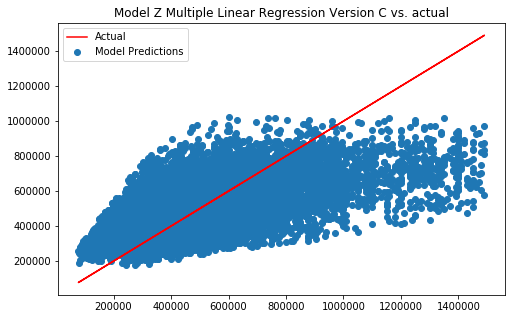

In [126]:

# Create a matplotlib figure
plt.figure(figsize=(8, 5))
# Create a scatter plot
plt.scatter(y_train, y_pred, label='Model Predictions')
plt.plot(y_train, y_train, label='Actual', color='r')
plt.title('Model Z Multiple Linear Regression Version C vs. actual')
plt.legend()
plt.show()